# m6A peaks and AD GWAS signals

- Data: we have m6A peaks (bed-file like) from different tissues, as well as a version merging all tissues. We also have multiple AD GWAS summary stats from different AD studies where we know the z-score for each variant we analyze, as well as if a variant is in 95% CS from fine-mapping.


## Overall
In this notebook, I aim to map m6A peaks to our finemapped AD variants to explore potential enrichment of m6A peaks. The steps are as follows:

1.	Organize m6A peak data, including:
- Conversion from hg19 to hg38 (not shown in this notebook)
- Check m6A peak sizes and downsize those larger than 1kb
- Annotate each peak with a possible associated gene
2.	Load AD finemapped data and Bellenguez sumstats to use as background.
3.	Map m6A peaks to AD finemapped and non-AD finemapped data.
4.	Perform enrichment analysis based on different contexts in Step 3.
5.	Compare whether this enrichment is brain-specific by examining the number of regions with or without AD variants in brain tissue compared to other tissues.

all GWAS analysis are focusing on Bellenguze in notebook

In [1]:
library(tidyverse)
library(data.table)
library(bedtoolsr)
library(GenomicRanges)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()   masks base::%||%()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Warning message in fun(libname, pkgname):
“bedtoolsr was built with bedtools version 2.30.0 but you have 

## Organize m6A data

combine m6A region file from all contexts together

In [7]:
# # file_name <- '~/data/m6A/hg38_convert/GSE114150_Brain_hg19Tohg38.bed'
# m6a = data.frame()
# for(file_name in list.files('~/data/m6A/hg38_convert/', 'bed$',full.names = T)){
#     m6a_tmp <- fread(file_name) %>% mutate(hg38_ID = paste(V1,V2,V3, sep = ":"), context = basename(file_name) %>% gsub('_hg19Tohg38.bed','',.))
#     m6a <- rbind(m6a, m6a_tmp)
# }


### Check the size of m6A peaks. If the peak is > 1 Kb, take the center and extend 500 bp on each side.

In [8]:
# m6a <- m6a %>% mutate(distance = V3-V2, 
#                center = as.integer((V2+V3)/2),
#                start = ifelse(distance <= 1000, V2, center - 500), 
#                end = ifelse(distance <= 1000, V3, center + 500)) 
# m6a %>% fwrite(., '~/data/m6A/hg38_convert/GSE114150_hg19Tohg38.all.modifyregion.bed.gz', sep = '\t')

combined 2 batches of peak data

In [2]:
m6a1 <- fread('~/data/m6A/hg38_convert/GSE114150_hg19Tohg38.all.modifyregion.bed.gz')
m6a2 <- fread('~/data/m6A/m6A_RELIC/m6A_adult.all.modifyregion.bed.gz')
m6a <- rbind(m6a1, m6a2, fill=T)

Add gene information into each peak. 
For the peak region we can keep every gene overlapped with it , and for the regions not covered with any gene body we pick the one with nearest TSS to center of m6A region

In [3]:
gene_region <- fread('~/data/ref_data_Ru/gene_region.tsv')

gene_region <- gene_region %>%
  mutate(gene_name = str_extract(V9, 'gene_name.*?;'), 
         gene_name = str_replace_all(gene_name, 'gene_name\\s*""?|""|;', ""),
        TSS = ifelse(V7 == "+", V4, V5))

In [4]:
# we only kept protein coding gene here
pro_gene_region <- gene_region %>% filter(str_detect(V9, "protein_coding")) 

colnames(pro_gene_region)[1] <- 'V1'
pro_gene_region %>% dim


[1] 19933    12

In [5]:
m6a %>% dim
m6a %>% head

[1] 605679     11

V1,V2,V3,V4,hg38_ID,context,distance,center,start,end,V5
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>
chr1,788796,789694,1:724176:725074,chr1:788796:789694,GSE114150_Brain,898,789245,788796,789694,NA
chr1,789859,790063,1:725239:725443,chr1:789859:790063,GSE114150_Brain,204,789961,789859,790063,NA
chr1,790159,790277,1:725539:725657,chr1:790159:790277,GSE114150_Brain,118,790218,790159,790277,NA
chr1,790486,790653,1:725866:726033,chr1:790486:790653,GSE114150_Brain,167,790569,790486,790653,NA
chr1,791162,791412,1:726542:726792,chr1:791162:791412,GSE114150_Brain,250,791287,791162,791412,NA
chr1,818005,818185,1:753385:753565,chr1:818005:818185,GSE114150_Brain,180,818095,818005,818185,NA


In [200]:
summary(m6a$end - m6a$start)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   156.0   247.0   346.9   444.0  1000.0 

### Overlap the m6A peaks and gene region annotation file

In [6]:
# Load necessary libraries

# Convert m6a peaks data and gene region data (pro_gene_region) to GRanges objects
m6a_gr <- GRanges(
  seqnames = m6a$V1,
  ranges = IRanges(start = m6a$start, end = m6a$end)
)

gene_gr <- GRanges(
  seqnames = pro_gene_region$V1,
  ranges = IRanges(start = pro_gene_region$V4, end = pro_gene_region$V5),
  gene_id = pro_gene_region$gene,
  gene_name = pro_gene_region$gene_name
)

For the peak region we can keep every gene overlapped with it 

In [7]:
# Find overlaps between m6a data and gene regions
overlaps <- findOverlaps(m6a_gr, gene_gr)

# Extract overlapping rows and annotate with gene information
m6a_with_gene <- m6a[queryHits(overlaps), ]
m6a_with_gene$gene_id <- pro_gene_region$gene[subjectHits(overlaps)]
m6a_with_gene$gene_name <- pro_gene_region$gene_name[subjectHits(overlaps)]

# For non-overlapping rows, find the nearest TSS
non_overlapping_indices <- setdiff(seq_len(nrow(m6a)), queryHits(overlaps))
m6a_no_gene <- m6a[non_overlapping_indices, ]

Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chrM
  - in 'y': chrMT
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning).”


for the regions not covered with any gene body we pick the one with nearest TSS to center of m6A region

In [8]:
# Convert non-overlapping data to GRanges object using the center column
m6a_center_gr <- GRanges(
  seqnames = m6a_no_gene$V1,
  ranges = IRanges(start = m6a_no_gene$center, end = m6a_no_gene$center),  # Use the center column
  strand = m6a_no_gene$strand
)

# Create a GRanges object for gene data using the TSS as the start and end coordinates
gene_tss_gr <- GRanges(
  seqnames = pro_gene_region$V1,
  ranges = IRanges(start = pro_gene_region$TSS, end = pro_gene_region$TSS),  # TSS is used for both start and end
  strand = pro_gene_region$V7,
  gene_id = pro_gene_region$gene,
  gene_name = pro_gene_region$gene_name
)

# Find the nearest TSS for m6A peaks using the center
nearest_tss_indices <- nearest(m6a_center_gr, gene_tss_gr)

Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chrM
  - in 'y': chrMT
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning).”


combine above together

In [9]:
# Add nearest gene info to non-overlapping peaks
m6a_no_gene$gene_id <- gene_tss_gr$gene_id[nearest_tss_indices]
m6a_no_gene$gene_name <- gene_tss_gr$gene_name[nearest_tss_indices]

# Combine overlapping and non-overlapping data
m6a_gene_anno <- bind_rows(m6a_with_gene, m6a_no_gene)

# Check dimensions and preview data
m6a_no_gene %>% dim()
m6a_gene_anno %>% head()

[1] 71425    13

V1,V2,V3,V4,hg38_ID,context,distance,center,start,end,V5,gene_id,gene_name
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>
chr1,958977,959238,1:894357:894618,chr1:958977:959238,GSE114150_Brain,261,959107,958977,959238,NA,ENSG00000188976,NOC2L
chr1,1027235,1027730,1:962615:963110,chr1:1027235:1027730,GSE114150_Brain,495,1027482,1027235,1027730,NA,ENSG00000188157,AGRN
chr1,1034120,1034622,1:969500:970002,chr1:1034120:1034622,GSE114150_Brain,502,1034371,1034120,1034622,NA,ENSG00000188157,AGRN
chr1,1043431,1043633,1:978811:979013,chr1:1043431:1043633,GSE114150_Brain,202,1043532,1043431,1043633,NA,ENSG00000188157,AGRN
chr1,1054842,1055887,1:990222:991267,chr1:1054842:1055887,GSE114150_Brain,1045,1055364,1054864,1055864,NA,ENSG00000188157,AGRN
chr1,1082006,1082102,1:1017386:1017482,chr1:1082006:1082102,GSE114150_Brain,96,1082054,1082006,1082102,NA,ENSG00000131591,C1orf159


In [10]:
1 - (m6a_no_gene %>% distinct(hg38_ID, context) %>% nrow) / (m6a_gene_anno %>% distinct(hg38_ID, context) %>% nrow)

[1] 0.8772765

 >87% peaks can be overlapped with gene body

## Load AD GWAS finemapping data
We focused on `AD_Bellenguez_2022` data and the variants in `cs_coverage_0.95_min_corr`

In [11]:
gwas <- fread('/mnt/vast/hpc/csg/rf2872/Work/Multivariate/GWAS_finemapping_Apr9/GWAS_finemapping_Apr9.union_export.tsv.gz')

gwas %>% dim
gwas <- gwas %>% 
        filter(study == 'AD_Bellenguez_2022') %>% 
        mutate(chr = str_split(variant_id, ":", simplify = T) %>% .[,1] %>% paste0("chr",.),
                pos = str_split(variant_id, ":", simplify = T) %>% .[,2] %>% as.numeric) %>% filter(cs_coverage_0.95_min_corr > 0)
gwas %>% head(n = 2)
gwas %>% dim

[1] 66479    15

variant_id,z,pip,cs_coverage_0.95,cs_coverage_0.7,cs_coverage_0.5,cs_coverage_0.95_min_corr,cs_coverage_0.7_min_corr,cs_coverage_0.5_min_corr,cs_coverage_0.95_attainable,cs_coverage_0.7_attainable,cs_coverage_0.5_attainable,study,method,block,chr,pos
<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
10:11676714:A:G,6.975610,0.979216533,1,1,1,1,1,1,1,1,1,AD_Bellenguez_2022,RSS_QC_RAISS_imputed,chr10_10500888_12817813,chr10,11676714
10:58094891:A:C,3.678899,0.001395639,1,0,0,1,0,0,NA,NA,NA,AD_Bellenguez_2022,RSS_QC_RAISS_imputed,chr10_57667362_59558848,chr10,58094891


[1] 1284   17

## Map m6A peaks to AD finemapped variants

In [12]:
m6a_gene_anno_bed <- m6a_gene_anno[, c("V1", "start", "end", "hg38_ID", "context", "gene_id", "gene_name")]
gwas_bed <- gwas[, .(chr, start_variant = as.integer(pos), end_variant = as.integer(pos), variant_id,z,pip,cs_coverage_0.95_min_corr,block, study)]

m6a_gene_bed_ad <- bt.intersect(a = m6a_gene_anno_bed, b = gwas_bed, wa = T, wb = T) 

In [13]:
colnames(m6a_gene_bed_ad) <- c("chrom", "start", "end", "hg38_ID", "context", "gene_id", "gene_name", colnames(gwas_bed))
m6a_gene_bed_ad %>% dim
m6a_gene_bed_ad %>% head

[1] 272  16

,chrom,start,end,hg38_ID,context,gene_id,gene_name,chr,start_variant,end_variant,variant_id,z,pip,cs_coverage_0.95_min_corr,block,study
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>
1,chr12,113158551,113159178,chr12:113158551:113159178,GSE114150_Brain,ENSG00000186710,CFAP73,chr12,113159061,113159061,12:113159061:G:A,4.575949,0.006127578,1,chr12_112825713_115165608,AD_Bellenguez_2022
2,chr12,113158551,113159178,chr12:113158551:113159178,GSE114150_Brain,ENSG00000123064,DDX54,chr12,113159061,113159061,12:113159061:G:A,4.575949,0.006127578,1,chr12_112825713_115165608,AD_Bellenguez_2022
3,chr12,113161821,113162088,chr12:113161821:113162088,GSE114150_Brain,ENSG00000123064,DDX54,chr12,113162061,113162061,12:113162061:T:C,4.490323,0.004234860,1,chr12_112825713_115165608,AD_Bellenguez_2022
4,chr12,113162795,113163180,chr12:113162795:113163180,GSE114150_Brain,ENSG00000123064,DDX54,chr12,113163098,113163098,12:113163098:A:G,4.483871,0.004119767,1,chr12_112825713_115165608,AD_Bellenguez_2022
5,chr12,113162795,113163180,chr12:113162795:113163180,GSE114150_Brain,ENSG00000123064,DDX54,chr12,113163135,113163135,12:113163135:C:T,4.518987,0.004788665,1,chr12_112825713_115165608,AD_Bellenguez_2022
6,chr12,113191735,113192015,chr12:113191735:113192015,GSE114150_Brain,ENSG00000139405,RITA1,chr12,113191832,113191832,12:113191832:G:A,4.449367,0.003557680,1,chr12_112825713_115165608,AD_Bellenguez_2022


The reginos numbers can have AD signals in each context are like below

In [14]:
m6a_gene_bed_ad %>% distinct(variant_id,context,hg38_ID, .keep_all = T) %>% pull(context) %>% table

.
      brain_cortex    GSE114150_Brain    GSE114150_Heart   GSE114150_Kidney 
                23                 18                 16                 26 
   GSE114150_Liver     GSE114150_Lung   GSE114150_merged   GSE114150_Muscle 
                11                  8                 30                 14 
GSE114150_Placenta  GSE114150_Stomach               hNPC 
                19                 10                 12 

In [16]:
fwrite(m6a_gene_bed_ad, "Oct17_GSE_Bellenguez_ADGWAS_cs95_mincorr_1kb.overlap.tsv", sep = '\t')

## Results for the comparison of annotated m6A peaks

### Figure 1: The consistency among different context/tissue
Define AD variants as variants in 95% CS from any AD GWAS data, we annotate these variants to see how many are m6A peaks. We see that brain m6A annotates more variants than other data-sets. Notice that this is variant level summary not CS level --- you can imagine limitations summarizing it this way, and how this can be improved to loci level summary if needed. I did not push it because I dont think we will use the UpsetR plot anyways, and I will get loci level information in the FET section i suggested.

brain_cortex    GSE114150_Brain    GSE114150_Heart   GSE114150_Kidney 
                 7                 18                 16                 26 
   GSE114150_Liver     GSE114150_Lung   GSE114150_merged   GSE114150_Muscle 
                11                  8                 30                 14 
GSE114150_Placenta  GSE114150_Stomach               hNPC 
                19                 10                  7

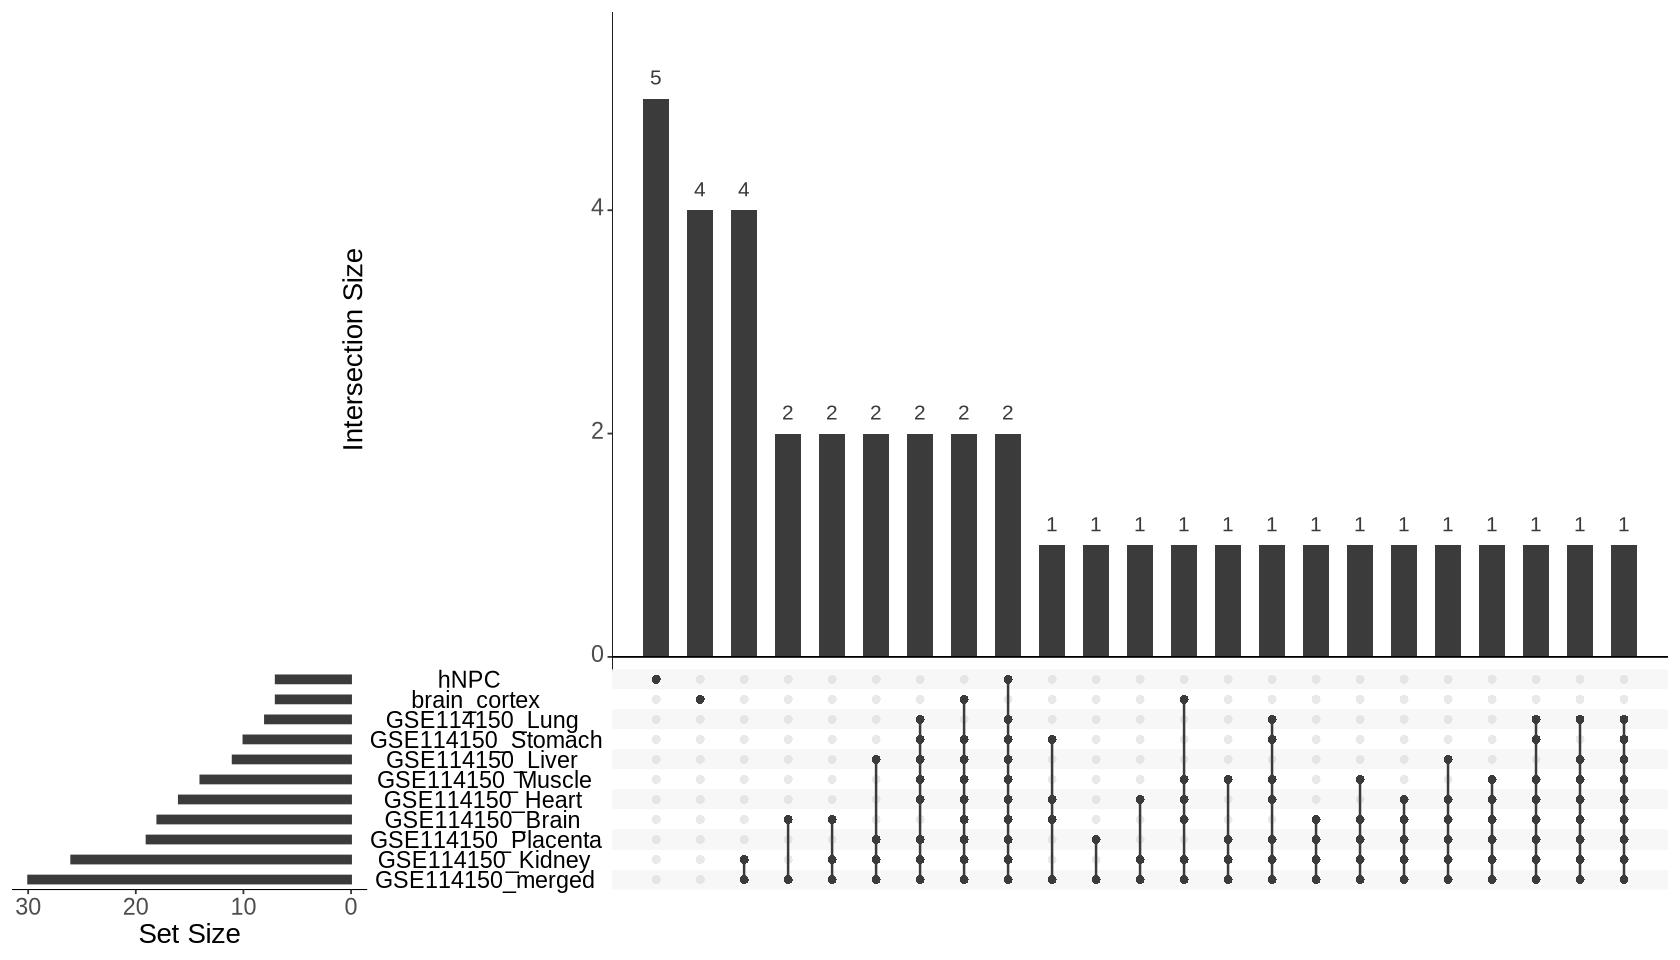

In [17]:
library(UpSetR)
library(tidyr)
library(dplyr)

options(repr.plot.width=14, repr.plot.height=8)
upset_data <- m6a_gene_bed_ad %>%
  select(variant_id, context) %>%
  distinct() %>%
  mutate(present = 1) %>%
  spread(key = context, value = present, fill = 0)
upset_data[,-1]%>% colSums
# Plot the UpSet plot to show how many variants are shared by contexts
upset(upset_data, sets = colnames(upset_data)[-1], order.by = "freq", text.scale = 2)

### Figure 2: Summarize the proportion of AD risk variants covered by peaks for each context and chromosome
Given a CS contain m6A peaks, we want to see what's the proportion of variants in the CS are m6A peaks. It's like how "pure" or "enriched" a CS is in terms of m6A modification. The goal here is to rule out if we have a very large CS with just one or two variants being m6A sites. And also to see if the overlap is not cluttered on a certain chromosome with large CS --- these are not clear from upsetR plot. Since we condition on CS containing m6A peak this is a relative metric and explains why brain has move CS+m6A overlaps than kidney but within those that are overlap, they behave similar. As I said I think this figure is more of a diagnosis although it does complement Figure 1 to further suggest that brain is interesting.

In [18]:
# Create a contingency table for intersected_data by context and chr
m6a_gene_bed_ad_table <- table(m6a_gene_bed_ad$context, m6a_gene_bed_ad$chrom)

# Create a table of gwas_bed counts by chromosome
gwas_chr_table <- table(gwas_bed$chr)

# Subset gwas_chr_table for chromosomes in intersected_table and repeat rows to match contexts
gwas_chr_counts <- gwas_chr_table[match(colnames(m6a_gene_bed_ad_table), names(gwas_chr_table))]

# Create a matrix where each row corresponds to a context and contains the chr counts from gwas_bed
gwas_chr_matrix <- matrix(gwas_chr_counts, nrow = nrow(m6a_gene_bed_ad_table), ncol = length(gwas_chr_counts), byrow = TRUE)

# Normalize the intersected_table by the corresponding gwas_bed counts
normalized_table <- m6a_gene_bed_ad_table / gwas_chr_matrix


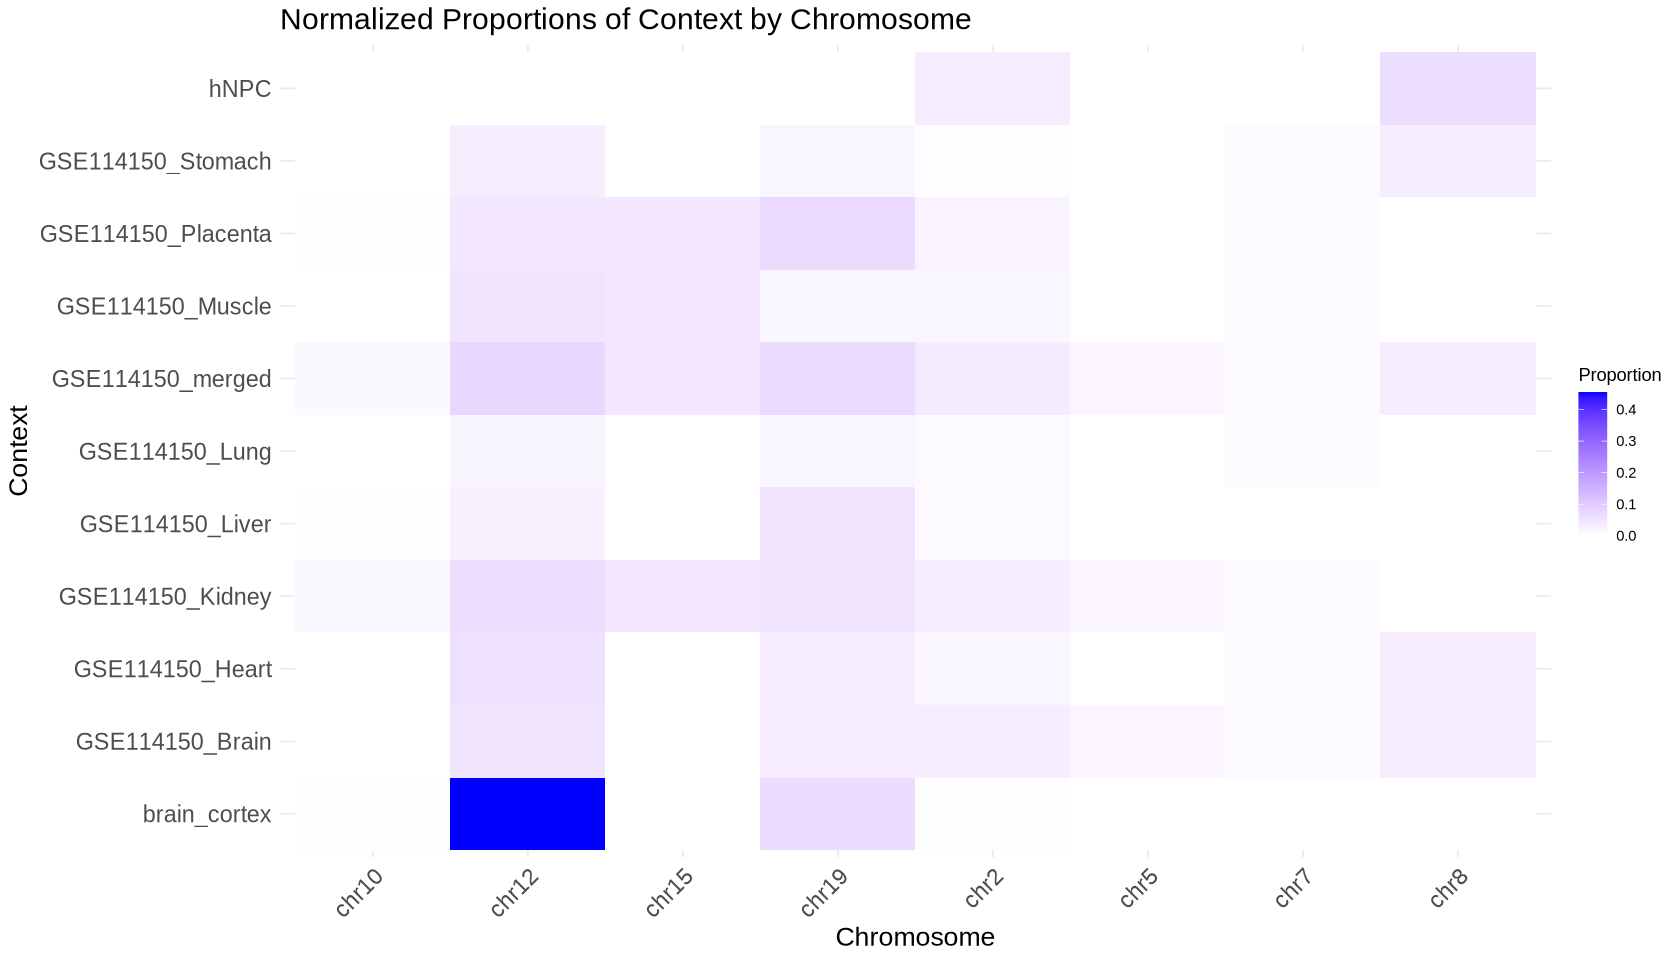

In [19]:
# Convert normalized_table to a data frame
normalized_df <- as.data.frame(as.table(normalized_table))

# Rename columns for clarity
colnames(normalized_df) <- c("Context", "Chromosome", "Proportion")
library(ggplot2)

# Plot the normalized table as a heatmap
ggplot(normalized_df, aes(x = Chromosome, y = Context, fill = Proportion)) +
  geom_tile() +   # Use tiles for the heatmap
  scale_fill_gradient(low = "white", high = "blue") +  # Customize colors
  labs(title = "Normalized Proportions of Context by Chromosome",
       x = "Chromosome", 
       y = "Context",
       fill = "Proportion") +
  theme_minimal() +
  theme(  axis.text.x = element_text(angle = 45, hjust = 1, size = 14),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 14),  # Increase font size for y-axis labels
    axis.title.x = element_text(size = 16),  # Increase font size for x-axis title
    axis.title.y = element_text(size = 16),  # Increase font size for y-axis title
    plot.title = element_text(size = 18)  # Increase font size for plot title
  ) 

## AD enrichment analysis 

fisher test with 1. m6A and AD loci, 2. m6a and not AD loci, 3. not m6a and AD loci, 4. not m6a and not AD loci

m6a_gene_bed_ad is the peak regions has AD variants in them 

In [20]:
m6a_gene_bed_ad %>% filter(context == 'GSE114150_merged') 

chrom,start,end,hg38_ID,context,gene_id,gene_name,chr,start_variant,end_variant,variant_id,z,pip,cs_coverage_0.95_min_corr,block,study
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>
chr10,58269167,58269407,chr10:58269167:58269407,GSE114150_merged,ENSG00000122873,CISD1,chr10,58269403,58269403,10:58269403:C:T,-4.010101,0.003389421,1,chr10_57667362_59558848,AD_Bellenguez_2022
chr10,96266187,96266701,chr10:96266187:96266701,GSE114150_merged,ENSG00000095585,BLNK,chr10,96266318,96266318,10:96266318:A:G,5.182243,0.032637387,1,chr10_95280986_98320874,AD_Bellenguez_2022
chr10,96266187,96266701,chr10:96266187:96266701,GSE114150_merged,ENSG00000095585,BLNK,chr10,96266554,96266554,10:96266554:A:G,5.205607,0.036940414,1,chr10_95280986_98320874,AD_Bellenguez_2022
chr10,96266187,96266701,chr10:96266187:96266701,GSE114150_merged,ENSG00000095585,BLNK,chr10,96266650,96266650,10:96266650:G:A,5.224299,0.040605957,1,chr10_95280986_98320874,AD_Bellenguez_2022
chr12,113158529,113159178,chr12:113158529:113159178,GSE114150_merged,ENSG00000186710,CFAP73,chr12,113159061,113159061,12:113159061:G:A,4.575949,0.006127578,1,chr12_112825713_115165608,AD_Bellenguez_2022
chr12,113158529,113159178,chr12:113158529:113159178,GSE114150_merged,ENSG00000123064,DDX54,chr12,113159061,113159061,12:113159061:G:A,4.575949,0.006127578,1,chr12_112825713_115165608,AD_Bellenguez_2022
chr12,113161818,113162088,chr12:113161818:113162088,GSE114150_merged,ENSG00000123064,DDX54,chr12,113162061,113162061,12:113162061:T:C,4.490323,0.004234860,1,chr12_112825713_115165608,AD_Bellenguez_2022
chr12,113162795,113163268,chr12:113162795:113163268,GSE114150_merged,ENSG00000123064,DDX54,chr12,113163098,113163098,12:113163098:A:G,4.483871,0.004119767,1,chr12_112825713_115165608,AD_Bellenguez_2022
chr12,113162795,113163268,chr12:113162795:113163268,GSE114150_merged,ENSG00000123064,DDX54,chr12,113163135,113163135,12:113163135:C:T,4.518987,0.004788665,1,chr12_112825713_115165608,AD_Bellenguez_2022


In [29]:
m6a_gene_bed_ad %>% filter(context %in% c('GSE114150_Brain','brain_cortex','hNPC')) 

chrom,start,end,hg38_ID,context,gene_id,gene_name,chr,start_variant,end_variant,variant_id,z,pip,cs_coverage_0.95_min_corr,block,study
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>
chr12,113158551,113159178,chr12:113158551:113159178,GSE114150_Brain,ENSG00000186710,CFAP73,chr12,113159061,113159061,12:113159061:G:A,4.575949,0.006127578,1,chr12_112825713_115165608,AD_Bellenguez_2022
chr12,113158551,113159178,chr12:113158551:113159178,GSE114150_Brain,ENSG00000123064,DDX54,chr12,113159061,113159061,12:113159061:G:A,4.575949,0.006127578,1,chr12_112825713_115165608,AD_Bellenguez_2022
chr12,113161821,113162088,chr12:113161821:113162088,GSE114150_Brain,ENSG00000123064,DDX54,chr12,113162061,113162061,12:113162061:T:C,4.490323,0.004234860,1,chr12_112825713_115165608,AD_Bellenguez_2022
chr12,113162795,113163180,chr12:113162795:113163180,GSE114150_Brain,ENSG00000123064,DDX54,chr12,113163098,113163098,12:113163098:A:G,4.483871,0.004119767,1,chr12_112825713_115165608,AD_Bellenguez_2022
chr12,113162795,113163180,chr12:113162795:113163180,GSE114150_Brain,ENSG00000123064,DDX54,chr12,113163135,113163135,12:113163135:C:T,4.518987,0.004788665,1,chr12_112825713_115165608,AD_Bellenguez_2022
chr12,113191735,113192015,chr12:113191735:113192015,GSE114150_Brain,ENSG00000139405,RITA1,chr12,113191832,113191832,12:113191832:G:A,4.449367,0.003557680,1,chr12_112825713_115165608,AD_Bellenguez_2022
chr12,113220931,113221081,chr12:113220931:113221081,GSE114150_Brain,ENSG00000166578,IQCD,chr12,113221042,113221042,12:113221042:G:A,4.563291,0.005799341,1,chr12_112825713_115165608,AD_Bellenguez_2022
chr12,113220931,113221081,chr12:113220931:113221081,GSE114150_Brain,ENSG00000186815,TPCN1,chr12,113221042,113221042,12:113221042:G:A,4.563291,0.005799341,1,chr12_112825713_115165608,AD_Bellenguez_2022
chr19,1854218,1854735,chr19:1854218:1854735,GSE114150_Brain,ENSG00000129911,KLF16,chr19,1854254,1854254,19:1854254:G:GC,-5.815217,0.165940073,1,chr19_1507536_3368979,AD_Bellenguez_2022


### load GWAS sumstats to get all GWAS variants 

In [22]:
all_gwas <- fread('/mnt/vast/hpc/csg/hs3393/RSS_QC/GWAS_finemapping_Apr9/RSS_QC_RAISS_imputed_concatenate_result/AD_Bellenguez_2022_RSS_QC_RAISS_imputed.tsv.gz')

In [23]:
# extract the GWAS table without AD loci
non_ad_df <- all_gwas %>% filter(!(variant_id %in% gwas[gwas$study =='AD_Bellenguez_2022',]$variant_id))%>% 
            mutate(chr = str_split(variant_id, ":", simplify = T) %>% .[,1] %>% paste0("chr",.),
                pos = str_split(variant_id, ":", simplify = T) %>% .[,2] %>% as.numeric) 

### map the m6a region to non-AD GWAS table

In [24]:
m6a_gene_anno_bed <- m6a_gene_anno[, c("V1", "start", "end", "hg38_ID", "context", "gene_id", "gene_name")]
non_adgwas_bed <- non_ad_df[, .(chr, start_variant = as.integer(pos), end_variant = as.integer(pos), variant_id)]

m6a_non_gene_bed_ad <- bt.intersect(a = m6a_gene_anno_bed, b = non_adgwas_bed, wa = T, wb = T) 

In [25]:
colnames(m6a_non_gene_bed_ad) <- c("chrom", "start", "end", "hg38_ID", "context", "gene_id", "gene_name", colnames(non_adgwas_bed))
m6a_non_gene_bed_ad %>% head

,chrom,start,end,hg38_ID,context,gene_id,gene_name,chr,start_variant,end_variant,variant_id
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>
1,chr1,958977,959238,chr1:958977:959238,GSE114150_Brain,ENSG00000188976,NOC2L,chr1,959139,959139,1:959139:G:A
2,chr1,958977,959238,chr1:958977:959238,GSE114150_Brain,ENSG00000188976,NOC2L,chr1,959193,959193,1:959193:G:A
3,chr1,1027235,1027730,chr1:1027235:1027730,GSE114150_Brain,ENSG00000188157,AGRN,chr1,1027340,1027340,1:1027340:C:T
4,chr1,1027235,1027730,chr1:1027235:1027730,GSE114150_Brain,ENSG00000188157,AGRN,chr1,1027450,1027450,1:1027450:T:G
5,chr1,1027235,1027730,chr1:1027235:1027730,GSE114150_Brain,ENSG00000188157,AGRN,chr1,1027511,1027511,1:1027511:C:T
6,chr1,1027235,1027730,chr1:1027235:1027730,GSE114150_Brain,ENSG00000188157,AGRN,chr1,1027633,1027633,1:1027633:C:T


### Enrichment analysis with fisher test
To generate 2x2 table:    
- ad_m6a: The number of variants within both AD loci and are m6A sites.
- ad_non_m6a: The number of variants within AD loci but not m6A sites.
- m6a_non_ad: The number of variants outside of AD loci but are m6A sites.
- non_m6a_non_ad: The number variants outside of AD loci also not m6A sites.
    
The first two categories can be calculated by finding the intersection between the m6A regions and the AD GWAS loci. The latter two categories can be calculated by finding the intersection between the m6A regions and the non-AD GWAS loci.

`intersected_data` from above analysis is the intersected table for m6A peak regions and AD GWAS loci table

`intersected_data_non_ad` here is the intersected table for m6A peak regions and non-AD GWAS loci table


The FET section: the table is focused on Bellenguez et al 2022 and is on variant level. Although I eyeballed 11 CS (we can get an accurate number) and I  know that Bellenguez has maybe 70 CS fine-mapped. So 11 out of 70 CS contain some m6A peaks. The test is still on variants though because I dont know how to make the test on CS ..

In [26]:
perform_fisher_test <- function(adgwas, all_gwas, m6a_ad, m6a_not_ad, test_context, greater = FALSE) {
  # Define the total number of AD variants
  ad <- length(adgwas[adgwas$study == 'AD_Bellenguez_2022',]$variant_id %>% unique())
  
  # Number of AD loci in m6A regions
  ad_m6a_df <- m6a_ad %>% filter(context %in% test_context)
  ad_m6a <- length(ad_m6a_df$variant_id %>% unique())
  
  # Number of AD loci outside m6A regions
  ad_non_m6a <- ad - ad_m6a
  
  # Total number of non-AD variants from GWAS concatenate sumstats
  non_ad <- length(all_gwas$variant_id %>% unique()) - ad
  
  # Number of non-AD loci in m6A regions
  m6a_non_ad_df <- m6a_not_ad %>% filter(context %in% test_context)
  m6a_non_ad <- length(m6a_non_ad_df$variant_id %>% unique())
  
  # Number of non-AD loci outside m6A regions
  non_m6a_non_ad <- non_ad - m6a_non_ad
  
  # Create the contingency table
  contingency_table <- matrix(c(ad_m6a, ad_non_m6a, m6a_non_ad, non_m6a_non_ad),
                              nrow = 2,
                              byrow = TRUE,
                              dimnames = list("AD" = c("AD", "not_AD"),
                                              "m6A" = c("m6A", "not_m6A")))
  

  # Perform Fisher's Exact Test
  if(greater) fisher_test_result <- fisher.test(contingency_table, alternative = "less") else fisher_test_result <- fisher.test(contingency_table)

  return(list(data = contingency_table, res = fisher_test_result))
}


In [27]:
# The number of variants within both AD loci and are m6A sites in different contexts
m6a_gene_bed_ad %>% distinct(context, variant_id, .keep_all = TRUE) %>% pull(context) %>% table

.
      brain_cortex    GSE114150_Brain    GSE114150_Heart   GSE114150_Kidney 
                 7                 18                 16                 26 
   GSE114150_Liver     GSE114150_Lung   GSE114150_merged   GSE114150_Muscle 
                11                  8                 30                 14 
GSE114150_Placenta  GSE114150_Stomach               hNPC 
                19                 10                  7 

In [28]:
# The number of variants within both non-AD loci and are m6A sites in different contexts
m6a_non_gene_bed_ad %>% distinct(context, variant_id, .keep_all = TRUE) %>% pull(context) %>% table

.
      brain_cortex    GSE114150_Brain    GSE114150_Heart   GSE114150_Kidney 
             42514              75191              42598              86650 
   GSE114150_Liver     GSE114150_Lung   GSE114150_merged   GSE114150_Muscle 
             38289              39834             140595              55354 
GSE114150_Placenta  GSE114150_Stomach               hNPC 
             64046              38073              25200 

Just show the details for `merged` and `Brain` here

In [30]:
# Two-sided test
perform_fisher_test(adgwas = gwas, all_gwas = all_gwas, m6a_ad = m6a_gene_bed_ad, m6a_not_ad = m6a_non_gene_bed_ad, test_context = c('GSE114150_Brain','brain_cortex','hNPC')) 

$data
        m6A
AD          m6A  not_m6A
  AD         27     1256
  not_AD 117002 12089633

$res

	Fisher's Exact Test for Count Data

data:  contingency_table
p-value = 0.0002374
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.457832 3.247748
sample estimates:
odds ratio 
   2.22118 



for other contexts, just show the pvalue for them ( two-sided)

In [31]:
contexts <- m6a_gene_anno_bed %>% pull(context) %>% unique
for(test_context in contexts){
    message(test_context,":",perform_fisher_test(adgwas = gwas, all_gwas = all_gwas, m6a_ad = m6a_gene_bed_ad, m6a_not_ad = m6a_non_gene_bed_ad, test_context = test_context)$res$p.value)
}

GSE114150_Brain:0.00170783178965425

GSE114150_Heart:1.82234233114467e-05

GSE114150_Kidney:3.2503989334749e-06

GSE114150_Liver:0.00292249902068156

GSE114150_Lung:0.0778295043433078

GSE114150_merged:0.000346147666541701

GSE114150_Muscle:0.00271227729392887

GSE114150_Placenta:7.50263296649612e-05

GSE114150_Stomach:0.00805683048277676

brain_cortex:0.22698141180543

hNPC:0.0186637752663764



In most contexts, there is an enrichment of AD loci in m6A regions, which may be inflated due to the non-independence of variants in LD?

## compare brain m6A peaks vs. m6A peaks in all other tissues
set A = brain specific, set B = both brain and other tissues, set C = other tissues but not brains. 


The test would be  1) number of "brain m6A" overlapping with Bellenguez 2022 AD CS  (AD CS hereafter) 2) number of "brain m6A" non-overlapping with AD CS, 3) number of "non-brain m6A" overlapping with AD CS , 4) number of "non-brain m6A" non-overlapping with AD CS.

when we talk about the overlap between peak regions here, if we only focus on the exactly region: same start and end. Then brain and other tissue do not have overlap. 

Loading required package: grid

Loading required package: futile.logger



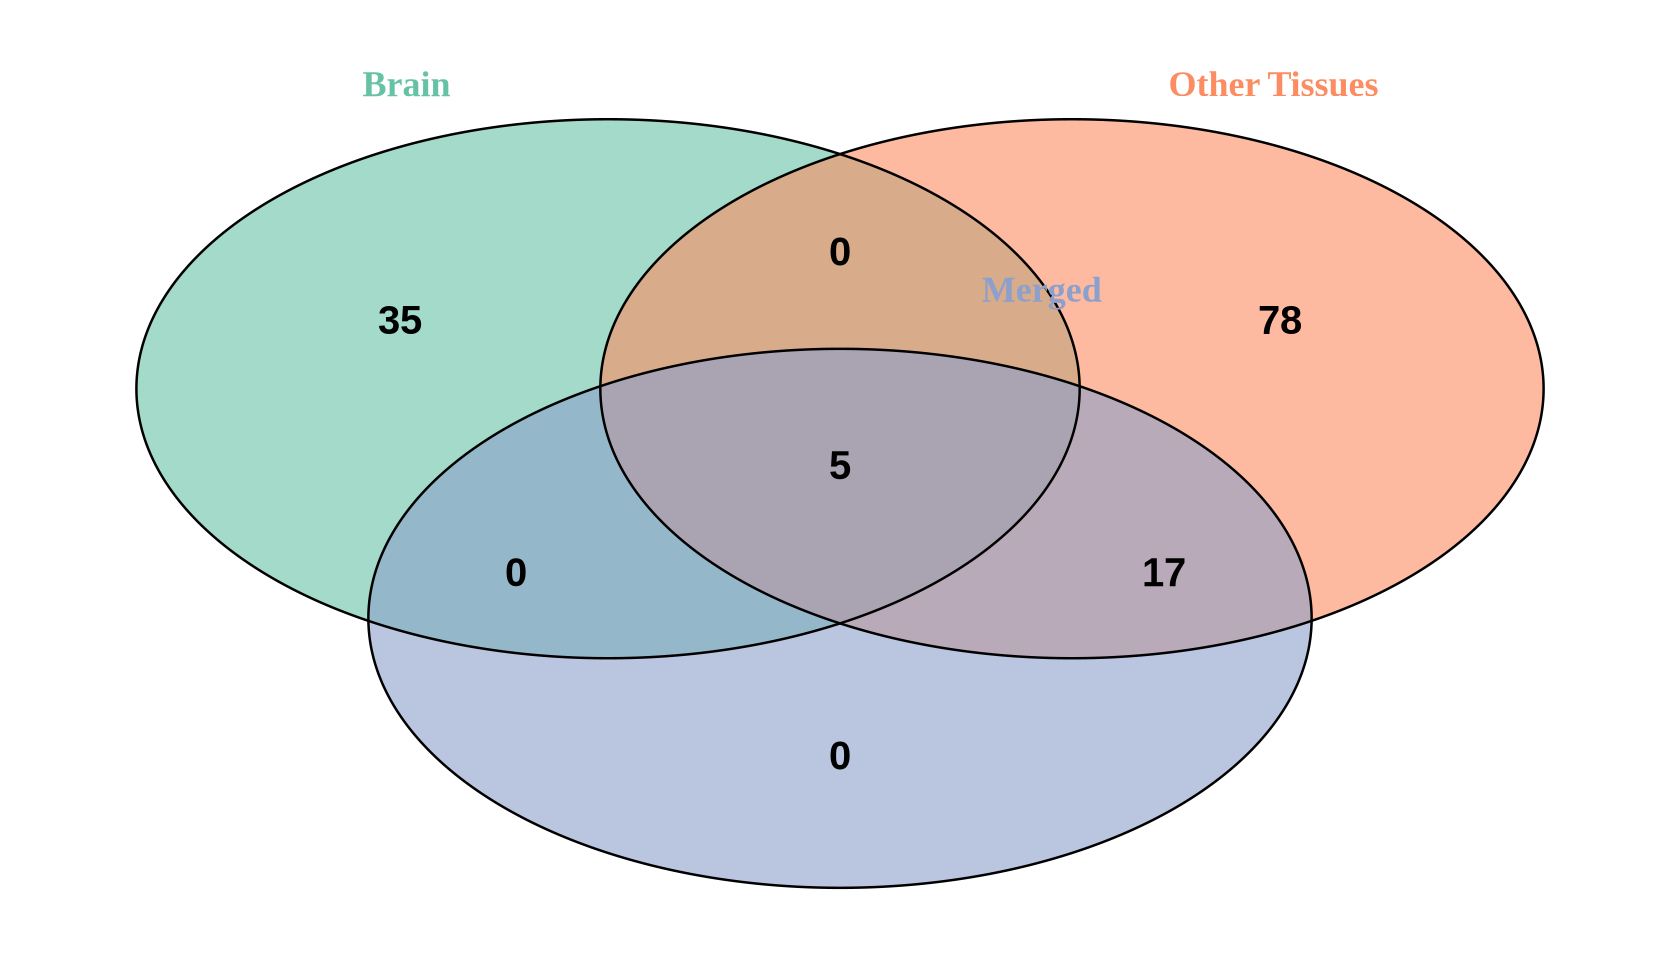

In [32]:
library(VennDiagram)
library(dplyr)

brain <- m6a_gene_bed_ad %>%
  filter(context %in% c('GSE114150_Brain','brain_cortex','hNPC')) %>%
  pull(hg38_ID)

other <- m6a_gene_bed_ad %>%
  filter(!(context %in% c('GSE114150_Brain','brain_cortex','hNPC')),!(context %in% c('GSE114150_Brain','brain_cortex','hNPC'))) %>%
  pull(hg38_ID)

merged <- m6a_gene_bed_ad %>%
  filter(context == 'GSE114150_merged') %>%
  pull(hg38_ID)

venn_data <- list(
  "Brain" = brain,
  "Other Tissues" = other,
  "Merged" = merged
)

venn.plot <- venn.diagram(
  x = venn_data,
  filename = NULL,  
  fill = c("#66c2a5", "#fc8d62", "#8da0cb"),  # 
  alpha = 0.6,  # 
  cex = 2,  # 
  fontface = "bold",  # 
  fontfamily = "sans",  # 
  cat.col = c("#66c2a5", "#fc8d62", "#8da0cb"),  # 
  cat.cex = 1.8,  # 
  cat.fontface = "bold",  # 
  cat.pos = c(-20, 20, 20),  # 
  cat.dist = c(0.05, 0.05, 0.05),  # 
  margin = 0.05,  # 
  lwd = 2,  # 
  lty = "solid",  # 
  col = "black"  # 
)

grid.draw(venn.plot)

If we accept overlapping regions, meaning that regions with different start and end coordinates (e.g., chr1:1-100 and chr1:20-120) can be considered the same, then almost all brain peaks are covered by peaks from other tissues. However, the numbers shown in the plot do not reflect the actual number of peaks, as they are influenced by the cutoffs applied to define peak regions. Moreover, I am unsure how to easily compare the regions based on this overlapping definition.

In [ ]:

# # Helper function to convert region string into GRanges object
# convert_to_granges <- function(region_list) {
#   parsed_regions <- do.call(rbind, strsplit(region_list, ":"))
#   gr <- GRanges(seqnames = parsed_regions[,1],
#                 ranges = IRanges(start = as.numeric(parsed_regions[,2]),
#                                  end = as.numeric(parsed_regions[,3])))
#   return(gr)
# }

# # Convert both region sets to GRanges
# gr_brain <- convert_to_granges(brain)
# gr_other <- convert_to_granges(other)

# # Find overlaps between the two sets
# overlaps <- findOverlaps(gr_brain, gr_other)

# # Prepare counts for Venn diagram
# unique_brain <- length(setdiff(seq_along(gr_brain), queryHits(overlaps)))
# unique_other <- length(setdiff(seq_along(gr_other), subjectHits(overlaps)))
# overlap_count <- length(queryHits(overlaps))

# # Generate Venn diagram
# venn.plot <- draw.pairwise.venn(area1 = unique_brain + overlap_count,
#                                 area2 = unique_other + overlap_count,
#                                 cross.area = overlap_count,
#                                 category = c("Brain", "Other"),
#                                 fill = c("#66c2a5", "#fc8d62"),
#                                 alpha = 0.5,
#                                 cex = 2,
#                                 cat.cex = 2,
#                                 cat.pos = c(-20, 20))

# # Display the Venn diagram
# grid.draw(venn.plot)

So I am here still using the former difinition to check sets, so there is actually no overlapped region between Brain and Other tissues, which means we don't have `B` set, the compare is simply between A and C

### use all AD signals in Bellenguez data here

#### compare brain and combined other tissues

#### A+B vs B+C

In [34]:
brain <- m6a_gene_anno_bed %>%
  filter(context %in% c('GSE114150_Brain','brain_cortex','hNPC'))  
brain_ad <- m6a_gene_bed_ad %>%
  filter(context %in% c('GSE114150_Brain','brain_cortex','hNPC')) %>% pull(hg38_ID) %>% unique %>% length
brain_nonad <- brain %>% pull(hg38_ID) %>% unique %>% length - brain_ad
brain_ad
brain_nonad

[1] 40

[1] 192180

In [43]:
other <- m6a_gene_anno_bed %>%
  filter(!(context %in% c('GSE114150_Brain','brain_cortex','hNPC')),!(context %in% c('GSE114150_Brain','brain_cortex','hNPC'))) 
other_ad <- m6a_gene_bed_ad %>%
  filter(!(context %in% c('GSE114150_Brain','brain_cortex','hNPC')),!(context %in% c('GSE114150_Brain','brain_cortex','hNPC')))  %>% pull(hg38_ID) %>% unique %>% length
other_nonad <- other %>% pull(hg38_ID) %>% unique %>% length - other_ad
other_ad
other_nonad

[1] 100

[1] 313753

In [44]:
# Create the contingency table
contingency_table <- matrix(c(brain_ad, brain_nonad, other_ad, other_nonad),
                            nrow = 2,
                            byrow = TRUE,
                            dimnames = list("Tissue" = c("Brain", "Other"),
                                            "AD" = c("AD", "not_AD")))

# Print the contingency table
print(contingency_table)

# Perform Fisher's Exact Test
# two sides
fisher_test_result_two <- fisher.test(contingency_table)
# one side
fisher_test_result_one <- fisher.test(contingency_table, alternative = "less")

# Print the Fisher test result
print(fisher_test_result_two)
print(fisher_test_result_one)

       AD
Tissue   AD not_AD
  Brian  40 192180
  Other 100 313753

	Fisher's Exact Test for Count Data

data:  contingency_table
p-value = 0.02331
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.4408235 0.9512129
sample estimates:
odds ratio 
 0.6530407 


	Fisher's Exact Test for Count Data

data:  contingency_table
p-value = 0.01249
alternative hypothesis: true odds ratio is less than 1
95 percent confidence interval:
 0.0000000 0.8991921
sample estimates:
odds ratio 
 0.6530407 



#### A+B vs C

In [65]:
brain <- m6a_gene_anno_bed %>%
  filter(context %in% c('GSE114150_Brain','brain_cortex','hNPC'))  
brain_ad_id <- m6a_gene_bed_ad %>%
  filter(context %in% c('GSE114150_Brain','brain_cortex','hNPC')) %>% pull(hg38_ID)


In [66]:
other <- m6a_gene_anno_bed %>%
  filter(!(context %in% c('GSE114150_Brain','brain_cortex','hNPC')),!(context %in% c('GSE114150_Brain','brain_cortex','hNPC'))) 
other_ad_id <- m6a_gene_bed_ad %>%
  filter(!(context %in% c('GSE114150_Brain','brain_cortex','hNPC')),!(context %in% c('GSE114150_Brain','brain_cortex','hNPC')))  %>% pull(hg38_ID) 


In [ ]:
B <- intersect(brain_ad_id, other_ad_id)

In [ ]:
brain_ad <- brain_ad_id %>% unique %>% length
brain_nonad <- brain %>% pull(hg38_ID) %>% unique %>% length - brain_ad
brain_ad
brain_nonad

In [ ]:
other_ad <- other_ad_id %>% unique %>% length - length(B)
other_nonad <- other %>% pull(hg38_ID) %>% unique %>% length - other_ad
other_ad
other_nonad

[1] 40

[1] 192180

[1] 95

[1] 313758

In [51]:
# Create the contingency table
contingency_table <- matrix(c(brain_ad, brain_nonad, other_ad, other_nonad),
                            nrow = 2,
                            byrow = TRUE,
                            dimnames = list("Tissue" = c("Brain", "Other"),
                                            "AD" = c("AD", "not_AD")))

# Print the contingency table
print(contingency_table)

# Perform Fisher's Exact Test
# two sides
fisher_test_result_two <- fisher.test(contingency_table)
# one side
fisher_test_result_one <- fisher.test(contingency_table, alternative = "less")

# Print the Fisher test result
print(fisher_test_result_two)
print(fisher_test_result_one)

       AD
Tissue  AD not_AD
  Brian 40 192180
  Other 95 313758

	Fisher's Exact Test for Count Data

data:  contingency_table
p-value = 0.05074
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.4627387 1.0045790
sample estimates:
odds ratio 
  0.687422 


	Fisher's Exact Test for Count Data

data:  contingency_table
p-value = 0.02653
alternative hypothesis: true odds ratio is less than 1
95 percent confidence interval:
 0.0000000 0.9491015
sample estimates:
odds ratio 
  0.687422 



#### A vs B+C

In [70]:
brain <- m6a_gene_anno_bed %>%
  filter(context %in% c('GSE114150_Brain','brain_cortex','hNPC'))  
brain_ad_id <- m6a_gene_bed_ad %>%
  filter(context %in% c('GSE114150_Brain','brain_cortex','hNPC')) %>% pull(hg38_ID)


In [71]:
other <- m6a_gene_anno_bed %>%
  filter(!(context %in% c('GSE114150_Brain','brain_cortex','hNPC')),!(context %in% c('GSE114150_Brain','brain_cortex','hNPC'))) 
other_ad_id <- m6a_gene_bed_ad %>%
  filter(!(context %in% c('GSE114150_Brain','brain_cortex','hNPC')),!(context %in% c('GSE114150_Brain','brain_cortex','hNPC')))  %>% pull(hg38_ID) 


In [72]:
B <- intersect(brain_ad_id, other_ad_id)

In [74]:
brain_ad <- brain_ad_id %>% unique %>% length - length(B)
brain_nonad <- brain %>% pull(hg38_ID) %>% unique %>% length - brain_ad
brain_ad
brain_nonad

[1] 35

[1] 192185

In [75]:
other_ad <- other_ad_id %>% unique %>% length
other_nonad <- other %>% pull(hg38_ID) %>% unique %>% length - other_ad
other_ad
other_nonad

[1] 100

[1] 313753

In [89]:
unique(m6a$hg38_ID) %>% length

[1] 484553

In [76]:
# Create the contingency table
contingency_table <- matrix(c(brain_ad, brain_nonad, other_ad, other_nonad),
                            nrow = 2,
                            byrow = TRUE,
                            dimnames = list("Tissue" = c("Brain", "Other"),
                                            "AD" = c("AD", "not_AD")))

# Print the contingency table
print(contingency_table)

# Perform Fisher's Exact Test
# two sides
fisher_test_result_two <- fisher.test(contingency_table)
# one side
fisher_test_result_one <- fisher.test(contingency_table, alternative = "less")

# Print the Fisher test result
print(fisher_test_result_two)
print(fisher_test_result_one)

       AD
Tissue   AD not_AD
  Brian  35 192185
  Other 100 313753

	Fisher's Exact Test for Count Data

data:  contingency_table
p-value = 0.003392
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.3772178 0.8474251
sample estimates:
odds ratio 
 0.5713963 


	Fisher's Exact Test for Count Data

data:  contingency_table
p-value = 0.002097
alternative hypothesis: true odds ratio is less than 1
95 percent confidence interval:
 0.0000000 0.7992191
sample estimates:
odds ratio 
 0.5713963 



#### compare brain and each other tissue (A+B vs B+C)

In [79]:
contexts <- m6a_gene_anno_bed %>% pull(context) %>% unique
# contexts <- contexts[contexts!= 'GSE114150_Brain' & contexts!= 'GSE114150_merged']
contexts <- contexts[!(contexts %in% c('GSE114150_Brain','brain_cortex','hNPC'))]

In [81]:
brain_ad <- brain_ad_id %>% unique %>% length
brain_ad

[1] 40

In [83]:
brain <- m6a_gene_anno_bed %>%
  filter(context %in% c('GSE114150_Brain','brain_cortex','hNPC'))  
brain_ad <- m6a_gene_bed_ad %>%
  filter(context %in% c('GSE114150_Brain','brain_cortex','hNPC')) %>% pull(hg38_ID) %>% unique %>% length
brain_nonad <- brain %>% pull(hg38_ID) %>% unique %>% length - brain_ad

for(context_target in contexts){
    other <- m6a_gene_anno_bed %>%
      filter(context %in% context_target) 
    other_ad <- m6a_gene_bed_ad %>%
      filter(context %in% context_target)  %>% pull(hg38_ID) %>% unique %>% length
    other_nonad <- other %>% pull(hg38_ID) %>% unique %>% length - other_ad
    
    # Create the contingency table
    contingency_table <- matrix(c(brain_ad, brain_nonad, other_ad, other_nonad),
                                nrow = 2,
                                byrow = TRUE,
                                dimnames = list("Tissue" = c("Brain", context_target),
                                                "AD" = c("AD", "not_AD")))

    message("Brain AD vs ", context_target, " AD")
    
    # Print the contingency table
    print(contingency_table)
        # two sides
    fisher_test_result_two <- fisher.test(contingency_table)
    # one side
    fisher_test_result_one <- fisher.test(contingency_table, alternative = "less")
    
    # Print the Fisher test result
    print(paste('Two-sided Fisher exact test pvalue:',fisher_test_result_two$p.value, 'with odds:', fisher_test_result_two$estimate))
    print(paste('One-sided Fisher exact test pvalue:',fisher_test_result_one$p.value, 'with odds:', fisher_test_result_one$estimate))
}

Brain AD vs GSE114150_Heart AD



                 AD
Tissue            AD not_AD
  Brain           40 192180
  GSE114150_Heart 13  34035
[1] "Two-sided Fisher exact test pvalue: 0.0798669773276005 with odds: 0.544924186423124"
[1] "One-sided Fisher exact test pvalue: 0.0474717761380388 with odds: 0.544924186423124"


Brain AD vs GSE114150_Kidney AD



                  AD
Tissue             AD not_AD
  Brain            40 192180
  GSE114150_Kidney 20  58513
[1] "Two-sided Fisher exact test pvalue: 0.0912703448140147 with odds: 0.608941326859937"
[1] "One-sided Fisher exact test pvalue: 0.0507575509050511 with odds: 0.608941326859937"


Brain AD vs GSE114150_Liver AD



                 AD
Tissue            AD not_AD
  Brain           40 192180
  GSE114150_Liver  8  31989
[1] "Two-sided Fisher exact test pvalue: 0.678036591259316 with odds: 0.832276172363369"
[1] "One-sided Fisher exact test pvalue: 0.376833999373478 with odds: 0.832276172363369"


Brain AD vs GSE114150_Lung AD



                AD
Tissue           AD not_AD
  Brain          40 192180
  GSE114150_Lung  6  30120
[1] "Two-sided Fisher exact test pvalue: 1 with odds: 1.04485825600217"
[1] "One-sided Fisher exact test pvalue: 0.604889716423336 with odds: 1.04485825600217"


Brain AD vs GSE114150_merged AD



                  AD
Tissue             AD not_AD
  Brain            40 192180
  GSE114150_merged 22  90676
[1] "Two-sided Fisher exact test pvalue: 0.586906151288917 with odds: 0.857880891668237"
[1] "One-sided Fisher exact test pvalue: 0.324678653737352 with odds: 0.857880891668237"


Brain AD vs GSE114150_Muscle AD



                  AD
Tissue             AD not_AD
  Brain            40 192180
  GSE114150_Muscle 11  37190
[1] "Two-sided Fisher exact test pvalue: 0.339214636377801 with odds: 0.703698859351318"
[1] "One-sided Fisher exact test pvalue: 0.194741065197104 with odds: 0.703698859351318"


Brain AD vs GSE114150_Placenta AD



                    AD
Tissue               AD not_AD
  Brain              40 192180
  GSE114150_Placenta 15  47946
[1] "Two-sided Fisher exact test pvalue: 0.177972738438143 with odds: 0.665295015166369"
[1] "One-sided Fisher exact test pvalue: 0.119715997712698 with odds: 0.665295015166369"


Brain AD vs GSE114150_Stomach AD



                   AD
Tissue              AD not_AD
  Brain             40 192180
  GSE114150_Stomach  7  26795
[1] "Two-sided Fisher exact test pvalue: 0.507967304024405 with odds: 0.796724755995968"
[1] "One-sided Fisher exact test pvalue: 0.350921405037717 with odds: 0.796724755995968"


There is no significant difference between Brain-AD enrichment and other tissue-AD enrichment. No matter for two-sided or one-sided. 

### in 245 gene list
Then I am wondering if we can get significant difference if we use our AD genelist as background... Which is a 245 genelist from our sharing QTL-AD sharing evidence, could be a potential AD risk gene list. 

#### compare brain and combined other tissues

In [93]:
ad_genes <- fread('/mnt/vast/hpc/csg/rf2872/data/resource_Ru/Fungen_xQTL.overlapped.gwas.min_corr_gwas95_qtl70.Apr.tsv')

In [94]:
brain <- m6a_gene_anno_bed %>%
  filter(context %in% c('GSE114150_Brain','brain_cortex','hNPC'), gene_id %in% ad_genes$region_id)  
brain_ad <- m6a_gene_bed_ad %>%
  filter(context %in% c('GSE114150_Brain','brain_cortex','hNPC'), gene_id %in% ad_genes$region_id) %>% pull(hg38_ID) %>% unique %>% length
brain_nonad <- (brain %>% pull(hg38_ID) %>% unique %>% length) - brain_ad
brain_ad
brain_nonad

[1] 17

[1] 4026

In [95]:
other <- m6a_gene_anno_bed %>%
  filter(context != 'GSE114150_Brain',!(context %in% c('GSE114150_Brain','brain_cortex','hNPC')), gene_id %in% ad_genes$region_id) 
other_ad <- m6a_gene_bed_ad %>%
  filter(context != 'GSE114150_Brain',!(context %in% c('GSE114150_Brain','brain_cortex','hNPC')), gene_id %in% ad_genes$region_id)  %>% pull(hg38_ID) %>% unique %>% length
other_nonad <- other %>% pull(hg38_ID) %>% unique %>% length - other_ad
other_ad
other_nonad

[1] 58

[1] 5782

In [96]:
# Create the contingency table
contingency_table <- matrix(c(brain_ad, brain_nonad, other_ad, other_nonad),
                            nrow = 2,
                            byrow = TRUE,
                            dimnames = list("Tissue" = c("Brain", "Other"),
                                            "AD" = c("AD", "not_AD")))

# Print the contingency table
print(contingency_table)

# Perform Fisher's Exact Test
# two sides
fisher_test_result_two <- fisher.test(contingency_table)
# one side
fisher_test_result_one <- fisher.test(contingency_table, alternative = "less")

# Print the Fisher test result
print(fisher_test_result_two)
print(fisher_test_result_one)

       AD
Tissue  AD not_AD
  Brain 17   4026
  Other 58   5782

	Fisher's Exact Test for Count Data

data:  contingency_table
p-value = 0.001297
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.2294586 0.7343725
sample estimates:
odds ratio 
 0.4209809 


	Fisher's Exact Test for Count Data

data:  contingency_table
p-value = 0.0006672
alternative hypothesis: true odds ratio is less than 1
95 percent confidence interval:
 0.0000000 0.6780796
sample estimates:
odds ratio 
 0.4209809 



#### compare brain and each other tissue

In [97]:
contexts <- m6a_gene_anno_bed %>% pull(context) %>% unique
contexts <- contexts[!(contexts %in% c('GSE114150_Brain','brain_cortex','hNPC'))]

In [98]:
brain <- m6a_gene_anno_bed %>%
  filter(context %in% c('GSE114150_Brain','brain_cortex','hNPC'), gene_id %in% ad_genes$region_id)  
brain_ad <- m6a_gene_bed_ad %>%
  filter(context %in% c('GSE114150_Brain','brain_cortex','hNPC'), gene_id %in% ad_genes$region_id) %>% pull(hg38_ID) %>% unique %>% length
brain_nonad <- brain %>% pull(hg38_ID) %>% unique %>% length - brain_ad

for(context_target in contexts){
    other <- m6a_gene_anno_bed %>%
      filter(context == context_target, gene_id %in% ad_genes$region_id) 
    other_ad <- m6a_gene_bed_ad %>%
      filter(context == context_target, gene_id %in% ad_genes$region_id)  %>% pull(hg38_ID) %>% unique %>% length
    other_nonad <- other %>% pull(hg38_ID) %>% unique %>% length - other_ad
    
    # Create the contingency table
    contingency_table <- matrix(c(brain_ad, brain_nonad, other_ad, other_nonad),
                                nrow = 2,
                                byrow = TRUE,
                                dimnames = list("Tissue" = c("Brain", context_target),
                                                "AD" = c("AD", "not_AD")))

    message("Brain AD vs ", context_target, " AD")
    
    # Print the contingency table
    print(contingency_table)
        # two sides
    fisher_test_result_two <- fisher.test(contingency_table)
    # one side
    fisher_test_result_one <- fisher.test(contingency_table, alternative = "less")
    
     # Print the Fisher test result
    print(paste('Two-sided Fisher exact test pvalue:',fisher_test_result_two$p.value, 'with odds:', fisher_test_result_two$estimate))
    print(paste('One-sided Fisher exact test pvalue:',fisher_test_result_one$p.value, 'with odds:', fisher_test_result_one$estimate))
}

Brain AD vs GSE114150_Heart AD



                 AD
Tissue            AD not_AD
  Brain           17   4026
  GSE114150_Heart  7    647
[1] "Two-sided Fisher exact test pvalue: 0.0671128823664204 with odds: 0.390400218134402"
[1] "One-sided Fisher exact test pvalue: 0.0400076374220546 with odds: 0.390400218134402"


Brain AD vs GSE114150_Kidney AD



                  AD
Tissue             AD not_AD
  Brain            17   4026
  GSE114150_Kidney 13   1065
[1] "Two-sided Fisher exact test pvalue: 0.00565356995854378 with odds: 0.346016515522075"
[1] "One-sided Fisher exact test pvalue: 0.00483963519945738 with odds: 0.346016515522075"


Brain AD vs GSE114150_Liver AD



                 AD
Tissue            AD not_AD
  Brain           17   4026
  GSE114150_Liver  5    575
[1] "Two-sided Fisher exact test pvalue: 0.184376971598073 with odds: 0.485685813977198"
[1] "One-sided Fisher exact test pvalue: 0.132373403250322 with odds: 0.485685813977198"


Brain AD vs GSE114150_Lung AD



                AD
Tissue           AD not_AD
  Brain          17   4026
  GSE114150_Lung  3    556
[1] "Two-sided Fisher exact test pvalue: 0.72708233445845 with odds: 0.782626104842636"
[1] "One-sided Fisher exact test pvalue: 0.445272733066076 with odds: 0.782626104842636"


Brain AD vs GSE114150_merged AD



                  AD
Tissue             AD not_AD
  Brain            17   4026
  GSE114150_merged 15   1576
[1] "Two-sided Fisher exact test pvalue: 0.0282708725670436 with odds: 0.443716249276424"
[1] "One-sided Fisher exact test pvalue: 0.0188200773582708 with odds: 0.443716249276424"


Brain AD vs GSE114150_Muscle AD



                  AD
Tissue             AD not_AD
  Brain            17   4026
  GSE114150_Muscle  5    654
[1] "Two-sided Fisher exact test pvalue: 0.221543011573333 with odds: 0.55239603754197"
[1] "One-sided Fisher exact test pvalue: 0.185751888173067 with odds: 0.55239603754197"


Brain AD vs GSE114150_Placenta AD



                    AD
Tissue               AD not_AD
  Brain              17   4026
  GSE114150_Placenta  9    837
[1] "Two-sided Fisher exact test pvalue: 0.0325126360311409 with odds: 0.392799876149823"
[1] "One-sided Fisher exact test pvalue: 0.0254573938573027 with odds: 0.392799876149823"


Brain AD vs GSE114150_Stomach AD



                   AD
Tissue              AD not_AD
  Brain             17   4026
  GSE114150_Stomach  3    510
[1] "Two-sided Fisher exact test pvalue: 0.486344624638883 with odds: 0.717896043866572"
[1] "One-sided Fisher exact test pvalue: 0.395123498975609 with odds: 0.717896043866572"


which is even more unsignificant...

### in different chromosome
what about if we focus on different chromosome?.. If there is some chromosome can show Brain peak specificty, e.g. chr19?

#### compare brain and combined other tissues

In [90]:
for(i in 1:22){
    chromosome = paste0('chr',i)
    message(chromosome)
    brain <- m6a_gene_anno_bed %>%
      filter(context %in% c('GSE114150_Brain','brain_cortex','hNPC'), V1 == chromosome)  
    brain_ad <- m6a_gene_bed_ad %>%
      filter(context %in% c('GSE114150_Brain','brain_cortex','hNPC'), chrom == chromosome) %>% pull(hg38_ID) %>% unique %>% length
    brain_nonad <- (brain %>% pull(hg38_ID) %>% unique %>% length) - brain_ad
    
    other <- m6a_gene_anno_bed %>%
      filter(context != 'GSE114150_Brain',!(context %in% c('GSE114150_Brain','brain_cortex','hNPC')), V1 == chromosome) 
    other_ad <- m6a_gene_bed_ad %>%
      filter(context != 'GSE114150_Brain',!(context %in% c('GSE114150_Brain','brain_cortex','hNPC')), chrom == chromosome)  %>% pull(hg38_ID) %>% unique %>% length
    other_nonad <- other %>% pull(hg38_ID) %>% unique %>% length - other_ad
    
    # Create the contingency table
    contingency_table <- matrix(c(brain_ad, brain_nonad, other_ad, other_nonad),
                                nrow = 2,
                                byrow = TRUE,
                                dimnames = list("Tissue" = c("Brain", "Other"),
                                                "AD" = c("AD", "not_AD")))
    
    # Perform Fisher's Exact Test
    # two sides
    fisher_test_result_two <- fisher.test(contingency_table)
    # one side
    fisher_test_result_one <- fisher.test(contingency_table, alternative = "less")
    
    # Print the Fisher test result
    print(paste('Two-sided Fisher exact test pvalue:',fisher_test_result_two$p.value, 'with odds:', fisher_test_result_two$estimate))
    print(paste('One-sided Fisher exact test pvalue:',fisher_test_result_one$p.value, 'with odds:', fisher_test_result_one$estimate))
}

chr1



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


chr2



[1] "Two-sided Fisher exact test pvalue: 0.617026210337101 with odds: 0.792991909288732"
[1] "One-sided Fisher exact test pvalue: 0.312139659819771 with odds: 0.792991909288732"


chr3



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


chr4



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


chr5



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0.862864263988636"
[1] "One-sided Fisher exact test pvalue: 0.694988552477589 with odds: 0.862864263988636"


chr6



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


chr7



[1] "Two-sided Fisher exact test pvalue: 0.163795732809965 with odds: 0.227771060715472"
[1] "One-sided Fisher exact test pvalue: 0.122475972939805 with odds: 0.227771060715472"


chr8



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 1.07111315412027"
[1] "One-sided Fisher exact test pvalue: 0.710455026326322 with odds: 1.07111315412027"


chr9



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


chr10



[1] "Two-sided Fisher exact test pvalue: 0.431476303677237 with odds: 0.3607213520339"
[1] "One-sided Fisher exact test pvalue: 0.306741002538812 with odds: 0.3607213520339"


chr11



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


chr12



[1] "Two-sided Fisher exact test pvalue: 0.491356902554451 with odds: 0.807767996820338"
[1] "One-sided Fisher exact test pvalue: 0.27434716585589 with odds: 0.807767996820338"


chr13



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


chr14



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


chr15



[1] "Two-sided Fisher exact test pvalue: 0.303822832990416 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 0.164402813026746 with odds: 0"


chr16



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


chr17



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


chr18



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


chr19



[1] "Two-sided Fisher exact test pvalue: 0.244446364479433 with odds: 0.493180731141171"
[1] "One-sided Fisher exact test pvalue: 0.123363619557514 with odds: 0.493180731141171"


chr20



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


chr21



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


chr22



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


Nothing specific if we compare Brain vs pooled_others, may beacause of not enough peaks per chromosome

#### compare brain and each other tissue

In [92]:
message('Print One-sided Fisher exact test pvalue < 0.7 only') 
message('Also printed 2x2 table since some test results have odds as Inf') 
for(i in 1:22){
    chromosome = paste0('chr',i)
    brain <- m6a_gene_anno_bed %>%
      filter(context %in% c('GSE114150_Brain','brain_cortex','hNPC'), V1 == chromosome)  
    brain_ad <- m6a_gene_bed_ad %>%
      filter(context %in% c('GSE114150_Brain','brain_cortex','hNPC'), chrom == chromosome) %>% pull(hg38_ID) %>% unique %>% length
    brain_nonad <- (brain %>% pull(hg38_ID) %>% unique %>% length) - brain_ad

    for(context_target in contexts){
        other <- m6a_gene_anno_bed %>%
          filter(context == context_target, V1 == chromosome) 
        other_ad <- m6a_gene_bed_ad %>%
          filter(context == context_target, chrom == chromosome)  %>% pull(hg38_ID) %>% unique %>% length
        other_nonad <- other %>% pull(hg38_ID) %>% unique %>% length - other_ad
        
        # Create the contingency table
        contingency_table <- matrix(c(brain_ad, brain_nonad, other_ad, other_nonad),
                                    nrow = 2,
                                    byrow = TRUE,
                                    dimnames = list("Tissue" = c("Brain", context_target),
                                                    "AD" = c("AD", "not_AD")))
    
        
            # two sides
        fisher_test_result_two <- fisher.test(contingency_table)
        # one side
        fisher_test_result_one <- fisher.test(contingency_table, alternative = "less")
        
        # Print the Fisher test result
        if (fisher_test_result_one$p.value < 0.1) {
    
            message("Brain AD vs ", context_target, " AD on ", chromosome)
            print(contingency_table)
            print(paste('One-sided Fisher exact test pvalue:',fisher_test_result_one$p.value, 'with odds:', fisher_test_result_one$estimate))
        }
    }
}

Print One-sided Fisher exact test pvalue < 0.7 only

Also printed 2x2 table since some test results have odds as Inf



## Case

In [99]:
brain <- m6a_gene_anno_bed %>%
  filter(context %in% c('GSE114150_Brain','brain_cortex','hNPC'))  
brain_ad_id <- m6a_gene_bed_ad %>%
  filter(context %in% c('GSE114150_Brain','brain_cortex','hNPC')) %>% pull(hg38_ID)


In [100]:
brain_ad_id

[1] "chr12:113158551:113159178" "chr12:113158551:113159178"
  [3] "chr12:113161821:113162088" "chr12:113162795:113163180"
  [5] "chr12:113162795:113163180" "chr12:113191735:113192015"
  [7] "chr12:113220931:113221081" "chr12:113220931:113221081"
  [9] "chr19:1854218:1854735"     "chr19:44859854:44860081"  
 [11] "chr2:134953245:134955180"  "chr2:134953245:134955180" 
 [13] "chr2:202843035:202843434"  "chr2:202924671:202925412" 
 [15] "chr2:202924671:202925412"  "chr2:202946450:202947523" 
 [17] "chr2:202946450:202947523"  "chr2:202946450:202947523" 
 [19] "chr2:202946450:202947523"  "chr2:202983419:202983739" 
 [21] "chr2:202983419:202983739"  "chr5:177515977:177516937" 
 [23] "chr7:100374156:100374656"  "chr8:27604960:27605366"   
 [25] "chr12:113159016:113159156" "chr12:113159016:113159156"
 [27] "chr12:113159016:113159156" "chr12:113159016:113159156"
 [29] "chr12:113159016:113159156" "chr12:113159016:113159156"
 [31] "chr12:113162998:113163165" "chr12:113162998:113163165"
 [33] "chr12:113163184:113164127" "chr12:113158888:113159170"
 [35] "chr12:113158888:113159170" "chr12:113158888:113159170"
 [37] "chr12:113158888:113159170" "chr12:113158888:113159170"
 [39] "chr12:113158888:113159170" "chr12:113162999:113163368"
 [41] "chr12:113162999:113163368" "chr12:113159016:113159156"
 [43] "chr12:113159016:113159156" "chr12:113159016:113159156"
 [45] "chr12:113159016:113159156" "chr12:113159016:113159156"
 [47] "chr12:113159016:113159156" "chr12:113162998:113163165"
 [49] "chr12:113162998:113163165" "chr12:113163184:113164127"
 [51] "chr2:202871461:202871765"  "chr12:113158906:113159116"
 [53] "chr12:113158906:113159116" "chr12:113158906:113159116"
 [55] "chr12:113158906:113159116" "chr12:113158906:113159116"
 [57] "chr12:113158906:113159116" "chr12:113162998:113164237"
 [59] "chr12:113162998:113164237" "chr19:1828363:1830708"    
 [61] "chr10:58267721:58267871"   "chr12:113158853:113159155"
 [63] "chr12:113158853:113159155" "chr12:113158853:113159155"
 [65] "chr12:113158853:113159155" "chr12:113158853:113159155"
 [67] "chr12:113158853:113159155" "chr12:113163005:113163356"
 [69] "chr12:113163005:113163356" "chr2:202871461:202871765" 
 [71] "chr12:113158906:113159116" "chr12:113158906:113159116"
 [73] "chr12:113158906:113159116" "chr12:113158906:113159116"
 [75] "chr12:113158906:113159116" "chr12:113158906:113159116"
 [77] "chr12:113162998:113164227" "chr12:113162998:113164227"
 [79] "chr19:1828363:1830708"     "chr12:113158986:113159156"
 [81] "chr12:113158986:113159156" "chr12:113158986:113159156"
 [83] "chr12:113158986:113159156" "chr12:113158986:113159156"
 [85] "chr12:113158986:113159156" "chr12:113163224:113164117"
 [87] "chr19:1828583:1830738"     "chr12:113158741:113159173"
 [89] "chr12:113158741:113159173" "chr12:113158741:113159173"
 [91] "chr12:113158741:113159173" "chr12:113158741:113159173"
 [93] "chr12:113158741:113159173" "chr12:113158986:113159156"
 [95] "chr12:113158986:113159156" "chr12:113158986:113159156"
 [97] "chr12:113158986:113159156" "chr12:113158986:113159156"
 [99] "chr12:113158986:113159156" "chr12:113163224:113164117"
[101] "chr19:1828583:1830758"     "chr2:134953447:134954208" 
[103] "chr2:134953447:134954208"  "chr2:202884498:202892690" 
[105] "chr2:202884498:202892690"  "chr8:27606436:27608633"   
[107] "chr8:27606436:27608633"    "chr2:134952676:134952845" 
[109] "chr2:134953490:134954260"  "chr2:134953490:134954260" 
[111] "chr2:134952717:134952798"  "chr2:134953447:134954208" 
[113] "chr2:134953447:134954208"  "chr2:202884498:202892700" 
[115] "chr2:202884498:202892700"

In [114]:
m6a_gene_bed_ad %>% head

,chrom,start,end,hg38_ID,context,gene_id,gene_name,chr,start_variant,end_variant,variant_id,z,pip,cs_coverage_0.95_min_corr,block,study
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>
1,chr12,113158551,113159178,chr12:113158551:113159178,GSE114150_Brain,ENSG00000186710,CFAP73,chr12,113159061,113159061,12:113159061:G:A,4.575949,0.006127578,1,chr12_112825713_115165608,AD_Bellenguez_2022
2,chr12,113158551,113159178,chr12:113158551:113159178,GSE114150_Brain,ENSG00000123064,DDX54,chr12,113159061,113159061,12:113159061:G:A,4.575949,0.006127578,1,chr12_112825713_115165608,AD_Bellenguez_2022
3,chr12,113161821,113162088,chr12:113161821:113162088,GSE114150_Brain,ENSG00000123064,DDX54,chr12,113162061,113162061,12:113162061:T:C,4.490323,0.004234860,1,chr12_112825713_115165608,AD_Bellenguez_2022
4,chr12,113162795,113163180,chr12:113162795:113163180,GSE114150_Brain,ENSG00000123064,DDX54,chr12,113163098,113163098,12:113163098:A:G,4.483871,0.004119767,1,chr12_112825713_115165608,AD_Bellenguez_2022
5,chr12,113162795,113163180,chr12:113162795:113163180,GSE114150_Brain,ENSG00000123064,DDX54,chr12,113163135,113163135,12:113163135:C:T,4.518987,0.004788665,1,chr12_112825713_115165608,AD_Bellenguez_2022
6,chr12,113191735,113192015,chr12:113191735:113192015,GSE114150_Brain,ENSG00000139405,RITA1,chr12,113191832,113191832,12:113191832:G:A,4.449367,0.003557680,1,chr12_112825713_115165608,AD_Bellenguez_2022


In [201]:
summary(m6a_gene_bed_ad$end - m6a_gene_bed_ad$start)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   81.0   221.0   360.0   472.3   703.5  1000.0 

In [123]:
gene_region <- fread('~/data/ref_data_Ru/gene_region.tsv')
gene_region %>% head

##collapsed version generated by GTEx pipeline,V2,V3,V4,V5,V6,V7,V8,V9,gene
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
chr1,havana,gene,11869,14409,.,+,.,"gene_id """"ENSG00000223972""""; transcript_id """"ENSG00000223972""""; gene_type """"transcribed_unprocessed_pseudogene""""; gene_name """"DDX11L1""""; transcript_type """"transcribed_unprocessed_pseudogene""""; transcript_name """"DDX11L1""""; gene_version """"5""""; gene_source """"havana"""";",ENSG00000223972
chr1,havana,gene,14404,29570,.,-,.,"gene_id """"ENSG00000227232""""; transcript_id """"ENSG00000227232""""; gene_type """"unprocessed_pseudogene""""; gene_name """"WASH7P""""; transcript_type """"unprocessed_pseudogene""""; transcript_name """"WASH7P""""; gene_version """"5""""; gene_source """"havana"""";",ENSG00000227232
chr1,mirbase,gene,17369,17436,.,-,.,"gene_id """"ENSG00000278267""""; transcript_id """"ENSG00000278267""""; gene_type """"miRNA""""; gene_name """"MIR6859-1""""; transcript_type """"miRNA""""; transcript_name """"MIR6859-1""""; gene_version """"1""""; gene_source """"mirbase"""";",ENSG00000278267
chr1,havana,gene,29554,31109,.,+,.,"gene_id """"ENSG00000243485""""; transcript_id """"ENSG00000243485""""; gene_type """"lncRNA""""; gene_name """"MIR1302-2HG""""; transcript_type """"lncRNA""""; transcript_name """"MIR1302-2HG""""; gene_version """"5""""; gene_source """"havana"""";",ENSG00000243485
chr1,mirbase,gene,30366,30503,.,+,.,"gene_id """"ENSG00000284332""""; transcript_id """"ENSG00000284332""""; gene_type """"miRNA""""; gene_name """"MIR1302-2""""; transcript_type """"miRNA""""; transcript_name """"MIR1302-2""""; gene_version """"1""""; gene_source """"mirbase"""";",ENSG00000284332
chr1,havana,gene,34554,36081,.,-,.,"gene_id """"ENSG00000237613""""; transcript_id """"ENSG00000237613""""; gene_type """"lncRNA""""; gene_name """"FAM138A""""; transcript_type """"lncRNA""""; transcript_name """"FAM138A""""; gene_version """"2""""; gene_source """"havana"""";",ENSG00000237613


In [143]:
m6a_gene_bed_ad_df <- merge(m6a_gene_bed_ad, gene_region %>% select(V4, V5, V7, gene), by.x = 'gene_id', by.y = 'gene')


In [144]:
# Rename the last two columns as gene_start and gene_end
colnames(m6a_gene_bed_ad_df)[ncol(m6a_gene_bed_ad_df) - 2] <- "gene_start"
colnames(m6a_gene_bed_ad_df)[ncol(m6a_gene_bed_ad_df) - 1] <- "gene_end"
colnames(m6a_gene_bed_ad_df)[ncol(m6a_gene_bed_ad_df)] <- "strand"

In [137]:
m6a_gene_bed_ad_df <- m6a_gene_bed_ad_df %>% mutate(gene_start_back = gene_start,
                             gene_start = ifelse(strand == '-', gene_end, gene_start),
                             gene_end = ifelse(strand == '-', gene_start_back, gene_end)) %>% select(-gene_start_back)

In [195]:
genes <- m6a_gene_bed_ad_df %>% pull(gene_name) %>% unique

In [247]:
library(ggplot2)
library(dplyr)
p <- list()
for(gene in genes){
    region_data <- m6a_gene_bed_ad_df %>% filter(gene_name == gene) 
    
    # Set extension length (e.g., 5000 bp upstream and downstream)
    extension <- 5000
        
    # Calculate plot boundaries
    plot_from <- min(region_data$gene_start, region_data$start, region_data$start_variant) - extension
    plot_to <- max(region_data$gene_end, region_data$end, region_data$end_variant) + extension
    gwas_region <- gwas %>% filter(chr == unique(region_data$chrom), pos >= plot_from, pos <= plot_to)
    gwas_region$cs_coverage_0.95_min_corr <- as.factor(gwas_region$cs_coverage_0.95_min_corr)
    non_overlap_peaks <- m6a_gene_anno %>% filter(gene_name == gene, !(hg38_ID %in% region_data$hg38_ID))


    # prepare data for each track 
    gene_data <- region_data %>%
          mutate(type = "Gene", start = gene_start, end = gene_end)
    peak_data <- region_data %>%
          mutate(type = "Peak", start = start, end = end)
        non_overlap_peaks <- m6a_gene_anno %>% filter(gene_name == gene, !(hg38_ID %in% region_data$hg38_ID))
    non_ovlp_peak_data <- non_overlap_peaks %>%
          mutate(type = "Peak", start = start, end = end)
    gwas_data <- gwas_region %>%
          mutate(type = "GWAS", start = pos, pip = pip)

   # Define custom color palette for contexts
    # Define custom color palette for contexts
    custom_colors <- c(
      "GSE114150_Brain" = "#8B0000",  # Dark Red
      "brain_cortex" = "#B22222",     # Firebrick Red
      "hNPC" = "#CD5C5C",             # Indian Red
      "Other" = "paleturquoise3"             # Pale Green
    )
    
    # Reorder peak data to prioritize brain-related contexts
    peak_data <- peak_data %>%
      mutate(context = ifelse(
        context %in% c("GSE114150_Brain", "brain_cortex", "hNPC"), 
        context, 
        "Other"
      )) %>%
      arrange(desc(context))  # Arrange so brain-related contexts come last (appear on top)
    
    non_ovlp_peak_data <- non_ovlp_peak_data %>%
      mutate(context = ifelse(
        context %in% c("GSE114150_Brain", "brain_cortex", "hNPC"), 
        context, 
        "Other"
      )) %>%
      arrange(desc(context))  # Same reordering for non-overlapping peaks
    
    # Plot using ggplot2
    p_region <- ggplot() +
      # Gene segments with arrows based on strand
      geom_segment(
        data = gene_data,
        aes(
          x = start, xend = end, 
          y = 1, yend = 1
        ),
        arrow = arrow(type = "open", angle = 25, length = unit(0.2, "inches")),  
        size = 1.5,
        lineend = "round"
      ) +
      # Rectangles for Peaks on their own track
      geom_rect(
        data = peak_data,
        aes(
          xmin = start, xmax = end, 
          ymin = 2.2, ymax = 2.8, 
          fill = context
        ),
        alpha = 0.5
      ) +
      # Rectangles for non-overlapping Peaks
      geom_rect(
        data = non_ovlp_peak_data,
        aes(
          xmin = start, xmax = end, 
          ymin = 1.5, ymax = 2.1, 
          fill = context
        ),
        alpha = 0.2
      ) +
      # GWAS PIP values as vertical segments
      geom_segment(
        data = gwas_data,
        aes(
          x = start, xend = start, 
          y = 3.1, yend = 3.1 + pip,
          color = as.factor(cs_coverage_0.95_min_corr)
        ),
        size = 1.2
      ) +
      # Labels for genes
      geom_text(
        data = gene_data,
        aes(
          x = (start + end) / 2, 
          y = 1.2, 
          label = gene_name
        ),
        size = 6
      ) +
      scale_y_continuous(
        limits = c(0.5, 3.5),
        breaks = c(1, 1.8, 2.4, 3.1), 
        labels = c("Gene", "Peak with AD", "Peak NOT with AD", "GWAS PIP")
      ) +
      # Apply custom colors for peak contexts
      scale_fill_manual(values = custom_colors) +
      # Use Brewer palette for discrete cs_coverage_0.95 values
      scale_color_brewer(palette = "Dark2") +
      theme_minimal() +
      theme(
        axis.title.y = element_blank(),
        axis.text.x = element_text(size = 16),
        axis.text.y = element_text(size = 16),
        plot.title = element_text(size = 20, face = "bold"),
        legend.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        panel.grid.major.y = element_blank(),
        panel.grid.minor = element_blank()
      ) +
      labs(
        title = paste("m6A Peaks, and GWAS PIP for", gene, "region"),
        x = "Genomic Position (bp)",
        fill = "Context",
        color = "CS Coverage (min corr)"
      ) +
      xlim(plot_from, plot_to)
    p[[gene]] <- p_region
    ggsave(paste0('plots/track_plots_',gene, '.pdf'),p_region, height = 6, width = 12)
}

Warning message:
"Removed 6 rows containing missing values or values outside the scale range
(`geom_rect()`)."
Warning message in RColorBrewer::brewer.pal(n, pal):
"n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors
"
Warning message:
"Removed 7 rows containing missing values or values outside the scale range
(`geom_segment()`)."


### show details of several interesting cases

Warning message:
"Removed 6 rows containing missing values or values outside the scale range
(`geom_rect()`)."


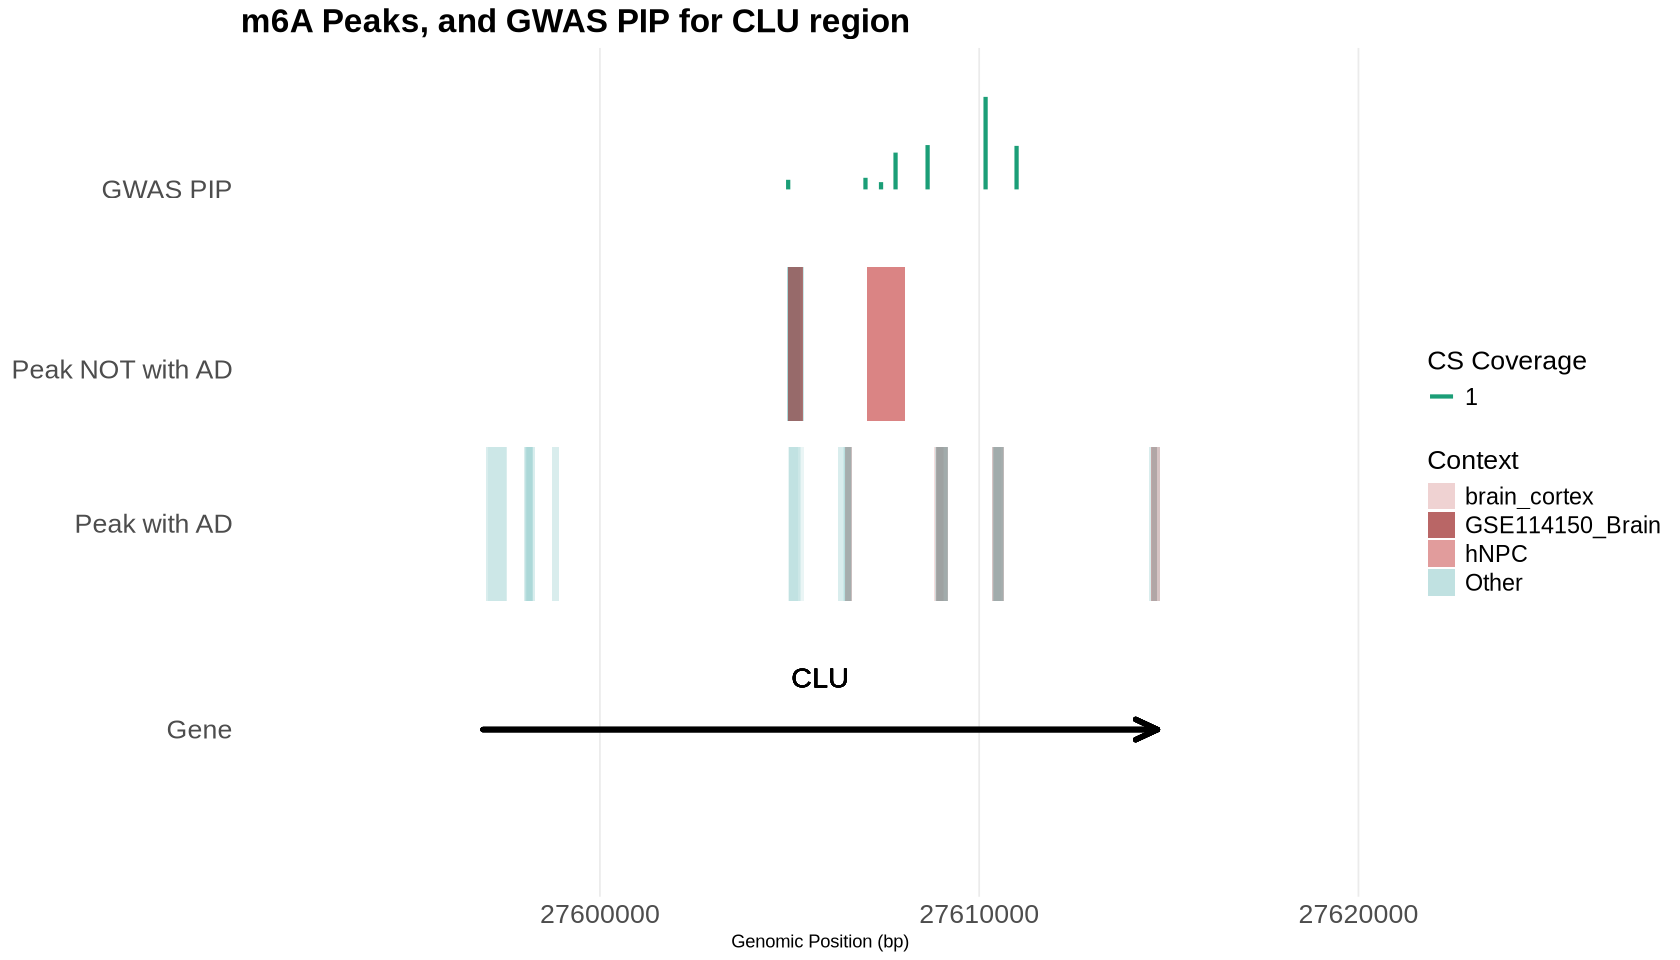

In [218]:
p[['CLU']]

CLU can be found with both cs_coverage_0.95 and cs_coverage_0.95_min_corr criteria

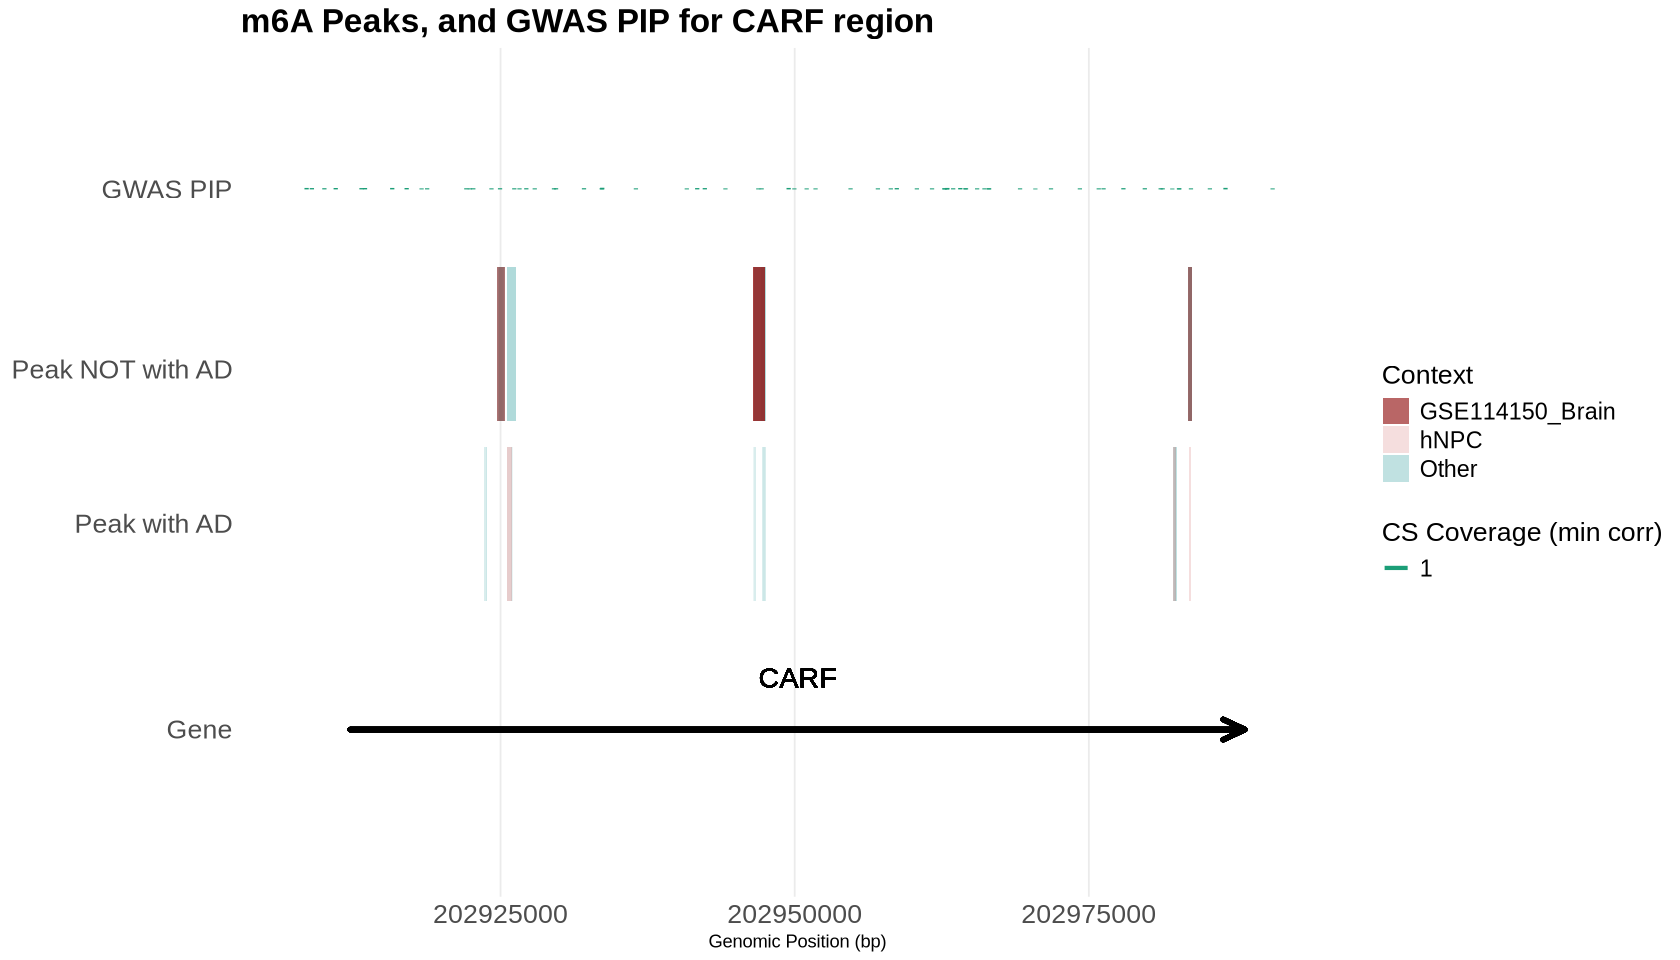

In [248]:
p[[12]]

In [254]:
region_data <- m6a_gene_bed_ad_df %>% filter(gene_name == 'CARF') 

extension <- 5000
    
plot_from <- min(region_data$gene_start, region_data$start, region_data$start_variant) - extension
plot_to <- max(region_data$gene_end, region_data$end, region_data$end_variant) + extension
gwas_region_block <- gwas %>% filter(chr == unique(region_data$chrom), pos >= plot_from, pos <= plot_to) %>% pull(block) %>% unique
gwas %>% filter(block == gwas_region_block, cs_coverage_0.95_min_corr == 1) %>% arrange(desc(pip)) %>% head
gwas %>% filter(block == gwas_region_block, cs_coverage_0.95_min_corr == 1) %>% arrange(desc(pip)) %>% dim

variant_id,z,pip,cs_coverage_0.95,cs_coverage_0.7,cs_coverage_0.5,cs_coverage_0.95_min_corr,cs_coverage_0.7_min_corr,cs_coverage_0.5_min_corr,cs_coverage_0.95_attainable,cs_coverage_0.7_attainable,cs_coverage_0.5_attainable,study,method,block,chr,pos
<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
2:202878716:TC:T,-5.163934,0.008586984,0,0,0,1,1,1,NA,NA,NA,AD_Bellenguez_2022,RSS_QC_RAISS_imputed,chr2_201677542_203951659,chr2,202878716
2:202833084:GA:G,-5.155738,0.008266730,0,0,0,1,1,1,NA,NA,NA,AD_Bellenguez_2022,RSS_QC_RAISS_imputed,chr2_201677542_203951659,chr2,202833084
2:202896433:TA:T,-5.139344,0.007661123,0,0,0,1,1,1,NA,NA,NA,AD_Bellenguez_2022,RSS_QC_RAISS_imputed,chr2_201677542_203951659,chr2,202896433
2:202821511:GTTTCC:G,-5.130081,0.007345753,0,0,0,1,1,1,NA,NA,NA,AD_Bellenguez_2022,RSS_QC_RAISS_imputed,chr2_201677542_203951659,chr2,202821511
2:202887295:G:A,-5.122951,0.007108885,0,0,0,1,1,1,NA,NA,NA,AD_Bellenguez_2022,RSS_QC_RAISS_imputed,chr2_201677542_203951659,chr2,202887295
2:202881162:T:C,-5.100000,0.006401449,0,0,0,1,1,1,NA,NA,NA,AD_Bellenguez_2022,RSS_QC_RAISS_imputed,chr2_201677542_203951659,chr2,202881162


[1] 226  17

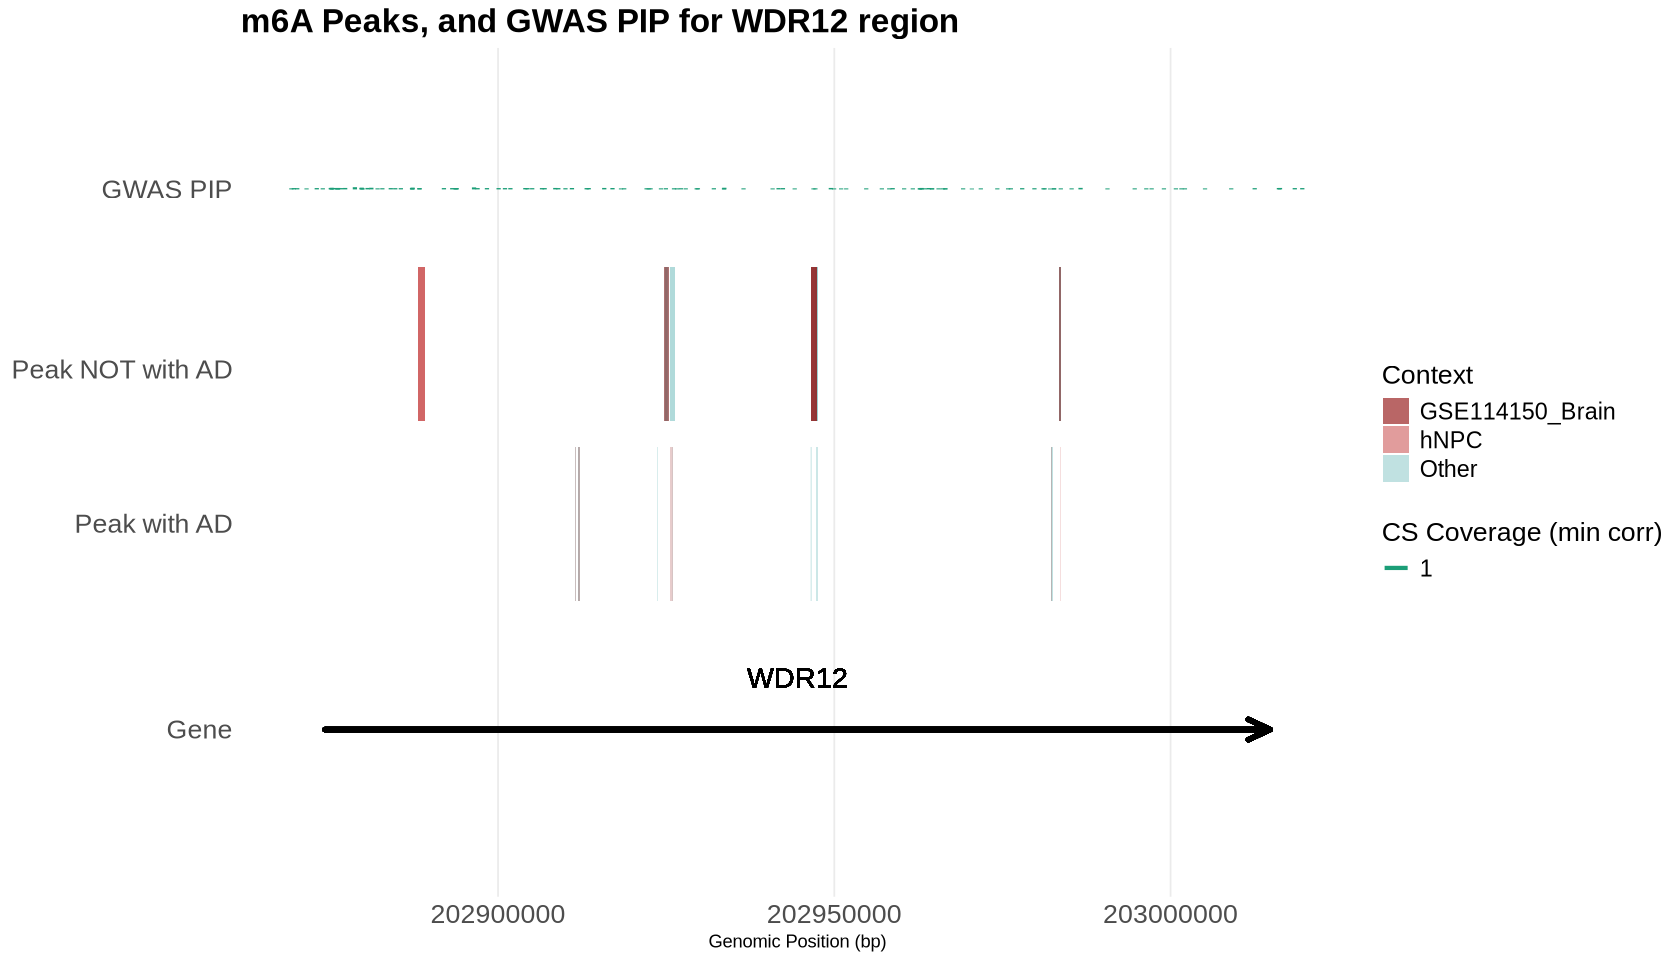

In [249]:
p[[13]]

In [251]:
region_data <- m6a_gene_bed_ad_df %>% filter(gene_name == 'WDR12') 

extension <- 5000
    
plot_from <- min(region_data$gene_start, region_data$start, region_data$start_variant) - extension
plot_to <- max(region_data$gene_end, region_data$end, region_data$end_variant) + extension
gwas_region_block <- gwas %>% filter(chr == unique(region_data$chrom), pos >= plot_from, pos <= plot_to) %>% pull(block) %>% unique
gwas %>% filter(block == gwas_region_block, cs_coverage_0.95_min_corr == 1) %>% arrange(desc(pip)) %>% head
gwas %>% filter(block == gwas_region_block, cs_coverage_0.95_min_corr == 1) %>% arrange(desc(pip)) %>% dim

variant_id,z,pip,cs_coverage_0.95,cs_coverage_0.7,cs_coverage_0.5,cs_coverage_0.95_min_corr,cs_coverage_0.7_min_corr,cs_coverage_0.5_min_corr,cs_coverage_0.95_attainable,cs_coverage_0.7_attainable,cs_coverage_0.5_attainable,study,method,block,chr,pos
<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
2:202878716:TC:T,-5.163934,0.008586984,0,0,0,1,1,1,NA,NA,NA,AD_Bellenguez_2022,RSS_QC_RAISS_imputed,chr2_201677542_203951659,chr2,202878716
2:202833084:GA:G,-5.155738,0.008266730,0,0,0,1,1,1,NA,NA,NA,AD_Bellenguez_2022,RSS_QC_RAISS_imputed,chr2_201677542_203951659,chr2,202833084
2:202896433:TA:T,-5.139344,0.007661123,0,0,0,1,1,1,NA,NA,NA,AD_Bellenguez_2022,RSS_QC_RAISS_imputed,chr2_201677542_203951659,chr2,202896433
2:202821511:GTTTCC:G,-5.130081,0.007345753,0,0,0,1,1,1,NA,NA,NA,AD_Bellenguez_2022,RSS_QC_RAISS_imputed,chr2_201677542_203951659,chr2,202821511
2:202887295:G:A,-5.122951,0.007108885,0,0,0,1,1,1,NA,NA,NA,AD_Bellenguez_2022,RSS_QC_RAISS_imputed,chr2_201677542_203951659,chr2,202887295
2:202881162:T:C,-5.100000,0.006401449,0,0,0,1,1,1,NA,NA,NA,AD_Bellenguez_2022,RSS_QC_RAISS_imputed,chr2_201677542_203951659,chr2,202881162


[1] 226  17

for $CARF$ and $WDR12$, the GWAS cs is only detected in cs_coverage_0.95_min_corr, probobaly because that cs is huge and without pip > 0.025 ( or some threshold) so be filtered in cs_coverage_0.95

## Conclusion:
1. In most contexts within the provided data, there is AD enrichment based on Fisher’s test results;
2. However, brain tissue does not show greater specificity for AD enrichment compared to other tissues;
3. While CLU can show some interesting pattern in specific region. 